In [1]:
import xarray as xr 
import os 
import numpy as np 
import sys 
import matplotlib.pyplot as plt 
import glob
import pickle
import xskillscore as xs

import torch
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import os
import cartopy.crs as ccrs


import torch
from torch.utils.data import Dataset
import numpy as np
import xarray as xr
import os
from sklearn.preprocessing import QuantileTransformer
from functools import lru_cache
from torch.utils.data import Dataset, DataLoader


import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torch.nn import Module, ModuleList
from torch.amp import autocast
from torch.utils.data import Dataset, DataLoader

from torch.optim import Adam

from torchvision import transforms as T, utils

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

from scipy.optimize import linear_sum_assignment

from PIL import Image
from tqdm.auto import tqdm
from ema_pytorch import EMA

from accelerate import Accelerator

from denoising_diffusion_pytorch.attend import Attend

from denoising_diffusion_pytorch.version import __version__
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

## Functions

In [2]:
def plot_ENSO_NA(slopes_diffy):
    levels = list(np.arange(-.7, .75, .05) * 1e-8)
    cmap = plt.get_cmap('RdBu_r')
    norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
    
    # Define fewer ticks for the colorbar
    fewer_ticks = [-7e-9, -5e-9, -3e-9, -1e-9, 1e-9, 3e-9, 5e-9, 7e-9]  # Select fewer representative levels
    
    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    
    # Set extent to zoom in on a particular region
    ax.set_extent([120, 300, 10, 80], crs=ccrs.PlateCarree())  # [min_lon, max_lon, min_lat, max_lat]
    
    # Color-filled plot for TREFHT with discrete levels
    prect_plot = slopes_diffy['PRECT'].plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap=cmap, 
        norm=norm, 
        add_colorbar=True, 
        cbar_kwargs={'boundaries': levels, 'ticks': fewer_ticks, 'shrink': 0.7}  # Shrink and reduce the number of ticks
    )
    plt.title('Regional Zoom: TREFHT (color) and PS (contours)')
    
    # Adding contour lines for PS
    contour = ax.contour(slopes_diffy['PS']['lon'], slopes_diffy['PS']['lat'], slopes_diffy['PS'], levels=10, colors='black', transform=ccrs.PlateCarree())
    ax.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')
    
    # Adding coastlines and formatting
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_xticks([120, 150, 180, 210, 240], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
    ax.set_yticks([10, 20, 30, 40, 50, 60], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))
    
    plt.tight_layout()
    plt.show()
    
def compute_regression_slopes(DS, region_lat=(-5, 5), region_lon=(190, 240)):
    """
    Compute the regression slopes of each variable (PS, PRECT, TREFHT) with respect to the mean of TREFHT
    over a specified region.

    Parameters:
    DS (xarray.Dataset): The dataset containing the variables.
    region_lat (tuple): Latitude bounds for selecting the region (default: (-5, 5)).
    region_lon (tuple): Longitude bounds for selecting the region (default: (190, 240)).

    Returns:
    dict: A dictionary containing the slope datasets for each variable (PS, PRECT, TREFHT).
    """
    
    # Step 1: Select the mean of TREFHT over the specified region
    trefht_mean = DS['TREFHT'].sel(lat=slice(*region_lat), lon=slice(*region_lon)).mean(dim=['lat', 'lon'])
    
    # Step 2: Demean the independent variable (TREFHT)
    trefht_mean_demeaned = trefht_mean - trefht_mean.mean(dim='samples')
    
    # Step 3: Loop over each variable and compute the slope at each (lat, lon) point
    regression_slopes = {}
    for var_name in ['PS', 'PRECT', 'TREFHT']:
        # Demean the dependent variable at each (lat, lon) point
        y = DS[var_name]
        y_demeaned = y - y.mean(dim='samples')
        
        # Compute the slope (cov(y, x) / var(x)) at each (lat, lon) point
        slope = (y_demeaned * trefht_mean_demeaned).mean(dim='samples') / (trefht_mean_demeaned ** 2).mean(dim='samples')
        
        # Store the slope result for this variable
        regression_slopes[var_name] = slope
    
    return regression_slopes


def closest_co2vmr_year(co2vmr, FNS):

    closest_diff = np.inf  # Initialize with a large value
    closest_time = None
    closest_file = None
    
    # Dictionary to store the time data from each file
    dict_times = {}

    for fn in FNS:
        # Open the dataset once per file
        CESM_LE = xr.open_dataset(fn)
        timers = CESM_LE['time'].values
        co2vmr_values = CESM_LE['co2vmr'].values

        # Store the time information in a dictionary for later retrieval
        dict_times[fn] = timers

        # Calculate the absolute difference for the CO₂ VMR values in this file
        abs_diff = np.abs(co2vmr_values - co2vmr)

        # Find the index of the minimum difference in this file
        min_index = np.argmin(abs_diff)

        # Update if the current file has a closer CO₂ VMR value
        if abs_diff[min_index] < closest_diff:
            closest_diff = abs_diff[min_index]
            closest_time = timers[min_index]
            closest_file = fn
            print('min dist:', abs_diff[min_index])

    # Return the year, month, and file name of the closest match
    return closest_time.year, closest_time.month, closest_file

def extract_closest_co2vmr_data(co2vmr, mt, var, FNS):
    """
    Extract data for the given variable where CO₂ VMR is closest to the target value for each file.
    
    Parameters:
    - co2vmr: The target CO₂ VMR value (float).
    - var: The variable name to extract (str).
    - FNS: List of file paths to NetCDF datasets (list of strings).
    
    Returns:
    - xarray.DataArray: DataArray containing the stacked data across all files, with dimensions 'time', 'lat', and 'lon'.
    """
    dats_list = []
    
    for fn in FNS:
        # Open the dataset
        CESM_LE = xr.open_dataset(fn)
        
        # Select March data (since CESM files are 1 month forward, we're using month == 3)
        feb_data = CESM_LE.where(CESM_LE['time.month'] == mt, drop=True)
        
        # Get the CO2 VMR values
        co2vmr_values = feb_data['co2vmr'].values
        
        # Calculate the absolute difference between the current CO₂ VMR values and the target
        abs_diff = np.abs(co2vmr_values - co2vmr)
        
        # Find the index of the minimum difference
        closest_index = np.argmin(abs_diff)
        
        # Extract the corresponding data point for the given variable at the closest CO₂ VMR
        dats_do = feb_data.isel(time=closest_index)[var].values
        
        # Append this data to the list
        dats_list.append(dats_do)
    
    # Stack the list of data arrays into a new dimension ('time')
    dats_stack = np.stack(dats_list, axis=0)
    
    # Get lat, lon, and time coordinates (assuming they are consistent across all files)
    lat = feb_data['lat'].values
    lon = feb_data['lon'].values
    times = np.arange(len(FNS))  # A new "time" dimension, you could modify this if actual time is needed.
    
    # Create an xarray DataArray from the stacked data
    dats_da = xr.DataArray(dats_stack, dims=['time', 'lat', 'lon'], coords={'time': times, 'lat': lat, 'lon': lon})
    
    return dats_da.to_dataset(name=var)


def concat_files_by_month(month_get, file_pattern):
    """
    Concatenate datasets along a 'samples' dimension, selecting data from a specific month.

    Parameters:
    month_get (int): The month to filter by (e.g., 2 for February).
    file_pattern (str): The glob pattern for the input NetCDF files.

    Returns:
    xarray.Dataset: Concatenated dataset along the 'samples' dimension.
    """
    # Step 1: Get the list of files
    FNS = sorted(glob.glob(file_pattern))

    # Step 2: Create an empty list to hold the filtered datasets
    datasets = []

    # Track the running count of samples
    sample_counter = 0

    # Step 3: Loop over each file and load the dataset, selecting only data for the given month
    for fps in FNS:
        # Open the dataset
        # print(fps)
        DS = xr.open_dataset(fps)

        # Select only data from the specified month
        mo_g = month_get+1

        if mo_g == 13:
            mo_g = 1
        
        DS_feb = DS.sel(time=DS['time.month'] == mo_g)

        # Determine the number of time steps in the current dataset
        n_samples = DS_feb.sizes['time']

        # Replace the 'time' dimension with 'samples' and increment the sample index
        DS_feb = DS_feb.rename({'time': 'samples'})  # Rename 'time' to 'samples'

        # Assign a new 'samples' coordinate, starting from the running sample counter
        DS_feb = DS_feb.assign_coords(samples=(sample_counter + np.arange(n_samples)))

        # Update the sample counter for the next dataset
        sample_counter += n_samples

        # Append the modified dataset to the list
        datasets.append(DS_feb)

    # Step 4: Concatenate along the new "samples" dimension
    DS_concat = xr.concat(datasets, dim='samples')

    return DS_concat

## Show regression maps

In [3]:
# import xarray as xr
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import matplotlib.colors as mcolors

# # Assuming your dataset is already loaded and slope_PS and slope_TREFHT are calculated
# # Replace with the correct path to your dataset
# DS = xr.open_dataset(file_do)

# # Extracting the slope_PS and slope_TREFHT (for demonstration purpose assuming it's calculated)
# # slope_PS = DS['PS']  # Adjust based on how the slope was computed
# # slope_TREFHT = DS['TREFHT']  # Adjust based on how the slope was computed

# # Define discrete color levels
# levels = list(np.arange(-1.3,1.4,.1))
# levels
# cmap = plt.get_cmap('RdBu_r')
# norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

# # Plotting
# fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# # Color-filled plot for TREFHT with discrete levels
# prect_plot = slope_TREFHT.plot(
#     ax=ax, 
#     transform=ccrs.PlateCarree(), 
#     cmap=cmap, 
#     norm=norm, 
#     add_colorbar=True, 
#     cbar_kwargs={'boundaries': levels, 'ticks': levels}
# )
# plt.title('Global Plot: TREFHT (color) and PS (contours)')

# # Adding contour lines for PS
# contour = ax.contour(slope_PS['lon'], slope_PS['lat'], slope_PS, levels=10, colors='black', transform=ccrs.PlateCarree())
# ax.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')

# # Adding coastlines and formatting
# ax.coastlines()
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.set_xticks([120, 150, 180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120], crs=ccrs.PlateCarree())
# ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
# ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))

# plt.tight_layout()
# plt.show()


In [4]:
# import xarray as xr
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import matplotlib.colors as mcolors
# import numpy as np

# # Assuming your dataset is already loaded and slope_PS and slope_PRECT are calculated
# # Replace with the correct path to your dataset
# DS = xr.open_dataset(file_do)

# # Define discrete color levels
# levels = list(np.arange(-.7, .75, .05) * 1e-8)
# cmap = plt.get_cmap('RdBu_r')
# norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

# # Define fewer ticks for the colorbar
# fewer_ticks = [-7e-9, -5e-9, -3e-9, -1e-9, 1e-9, 3e-9, 5e-9, 7e-9]  # Select fewer representative levels

# # Plotting
# fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# # Set extent to zoom in on a particular region
# ax.set_extent([120, 300, 10, 80], crs=ccrs.PlateCarree())  # [min_lon, max_lon, min_lat, max_lat]

# # Color-filled plot for TREFHT with discrete levels
# prect_plot = slope_PRECT.plot(
#     ax=ax, 
#     transform=ccrs.PlateCarree(), 
#     cmap=cmap, 
#     norm=norm, 
#     add_colorbar=True, 
#     cbar_kwargs={'boundaries': levels, 'ticks': fewer_ticks, 'shrink': 0.7}  # Shrink and reduce the number of ticks
# )
# plt.title('Regional Zoom: TREFHT (color) and PS (contours)')

# # Adding contour lines for PS
# contour = ax.contour(slope_PS['lon'], slope_PS['lat'], slope_PS, levels=10, colors='black', transform=ccrs.PlateCarree())
# ax.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')

# # Adding coastlines and formatting
# ax.coastlines()
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.set_xticks([120, 150, 180, 210, 240], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
# ax.set_yticks([10, 20, 30, 40, 50, 60], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
# ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))

# plt.tight_layout()
# plt.show()


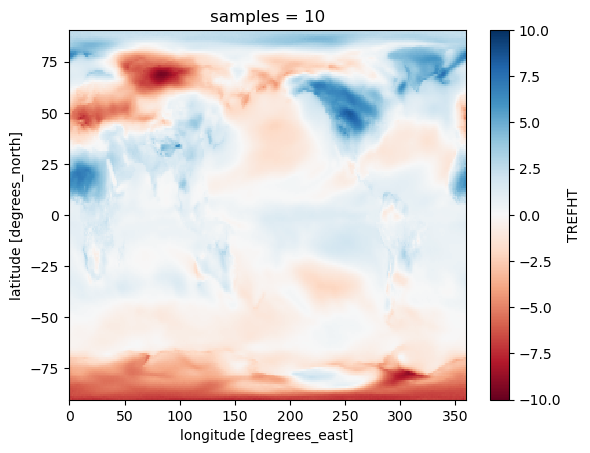

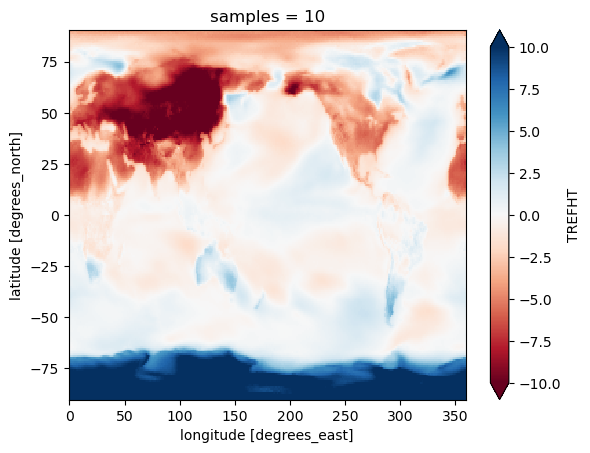

In [2]:
DS1 = xr.open_dataset('/glade/derecho/scratch/wchapman/Gen_CESM/samples_toyota_estates_month02_co20.0005750677712606138_001.nc')
Dmean1 = DS1['TREFHT'].mean('samples')
(DS1['TREFHT'].sel(samples=10)- Dmean1).plot(cmap='RdBu',vmin=-10, vmax=10)
plt.show()

DS2 = xr.open_dataset('/glade/derecho/scratch/wchapman/Gen_CESM/samples_nutten_ut_month02_co20.00039895_001.nc')
Dmean2 = DS2['TREFHT'].mean('samples')
(DS2['TREFHT'].sel(samples=10)- Dmean2).plot(cmap='RdBu',vmin=-10, vmax=10)
plt.show()

## compare to training

In [171]:
import glob
import numpy as np
import xarray as xr

# Example usage:
co2vmr = 0.0004421641313381595
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CESM_LE2_vars_BSSP370cmip6/*.2025*.nc'))
result_da_1 = xr.merge([extract_closest_co2vmr_data(co2vmr, 'TREFHT', FNS),extract_closest_co2vmr_data(co2vmr, 'PRECT', FNS),extract_closest_co2vmr_data(co2vmr, 'PS', FNS)])

co2vmr = 0.0004421641313381595
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CESM_LE2_vars_BSSP370cmip6/*.2025*.nc'))
result_da_2 = xr.merge([extract_closest_co2vmr_data(co2vmr, 'TREFHT', FNS),extract_closest_co2vmr_data(co2vmr, 'PRECT', FNS),extract_closest_co2vmr_data(co2vmr, 'PS', FNS)])

result_da= xr.merge([result_da_1,result_da_2])

## generate on exact numbers --> 

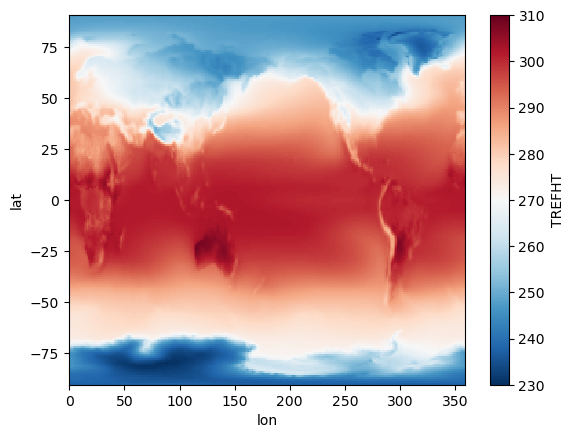

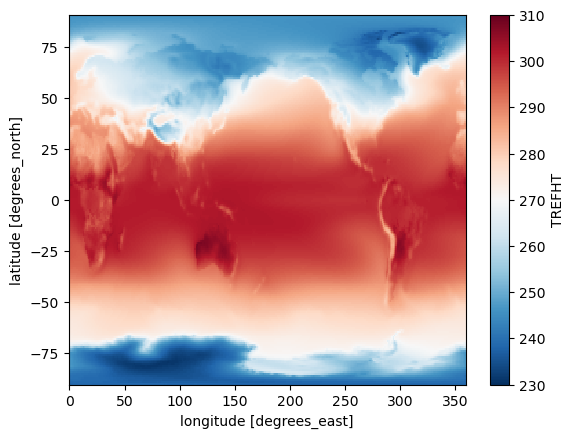

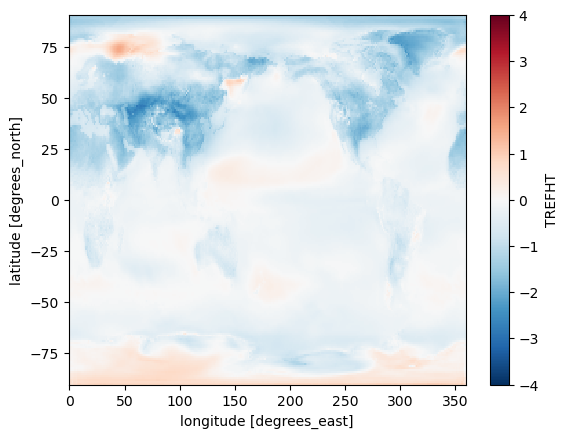

In [173]:
result_da['TREFHT'].mean('time').plot(cmap='RdBu_r',vmin=230,vmax=310)
plt.show()

DS1 = xr.open_dataset('/glade/derecho/scratch/wchapman/Gen_CESM/samples_toyota_estates_month02_co20.0005750677712606138_001.nc')
Dmean1 = DS1['TREFHT'].sel(samples=slice(0,500)).mean('samples')
Dmean1.plot(cmap='RdBu_r',vmin=230,vmax=310)
plt.show()

(Dmean1 - result_da['TREFHT'].mean('time')).plot(cmap='RdBu_r',vmin=-4,vmax=4)
plt.show()

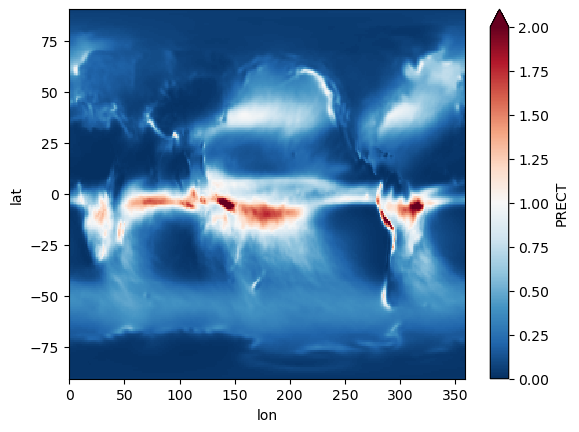

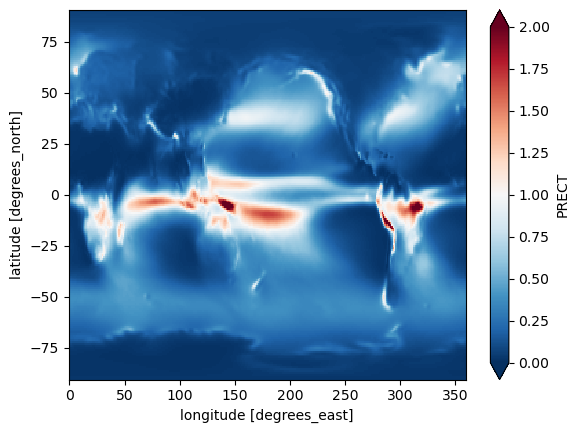

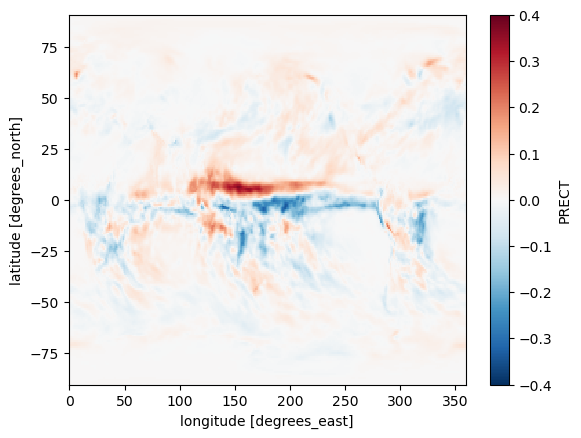

In [174]:
(result_da['PRECT'].mean('time')*1e7).plot(cmap='RdBu_r',vmin=0,vmax=2)
plt.show()

DS1 = xr.open_dataset('/glade/derecho/scratch/wchapman/Gen_CESM/samples_toyota_estates_month02_co20.0005750677712606138_001.nc')
Dmean1 = DS1['PRECT'].sel(samples=slice(0,500)).mean('samples')
(Dmean1*1e7).plot(cmap='RdBu_r',vmin=0,vmax=2)
plt.show()

((Dmean1 - result_da['PRECT'].mean('time'))*1e7).plot(cmap='RdBu_r',vmin=-.4,vmax=.4)
plt.show()

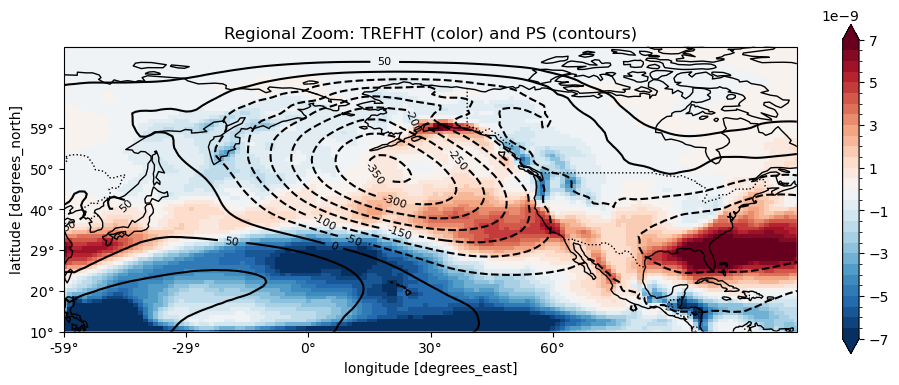

In [5]:
DS1 = xr.open_dataset('/glade/derecho/scratch/wchapman/Gen_CESM/samples_toyota_estates_month02_co20.0003991389897498876_001.nc')
slopes_diffy = compute_regression_slopes(DS1.sel(samples=slice(0,500)))
DS2 = xr.open_dataset('/glade/derecho/scratch/wchapman/Gen_CESM/samples_toyota_estates_month02_co20.0005750677712606138_001.nc')
slopes_diffy_DS2 = compute_regression_slopes(DS2.sel(samples=slice(0,500)))
# Assuming your dataset is already loaded and slope_PS and slope_PRECT are calculated
# Replace with the correct path to your dataset
# Define discrete color levels
levels = list(np.arange(-.7, .75, .05) * 1e-8)
cmap = plt.get_cmap('RdBu_r')
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

# Define fewer ticks for the colorbar
fewer_ticks = [-7e-9, -5e-9, -3e-9, -1e-9, 1e-9, 3e-9, 5e-9, 7e-9]  # Select fewer representative levels

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Set extent to zoom in on a particular region
ax.set_extent([120, 300, 10, 80], crs=ccrs.PlateCarree())  # [min_lon, max_lon, min_lat, max_lat]

# Color-filled plot for TREFHT with discrete levels
prect_plot = slopes_diffy['PRECT'].plot(
    ax=ax, 
    transform=ccrs.PlateCarree(), 
    cmap=cmap, 
    norm=norm, 
    add_colorbar=True, 
    cbar_kwargs={'boundaries': levels, 'ticks': fewer_ticks, 'shrink': 0.7}  # Shrink and reduce the number of ticks
)
plt.title('Regional Zoom: TREFHT (color) and PS (contours)')

# Adding contour lines for PS
contour = ax.contour(slopes_diffy['PS']['lon'], slopes_diffy['PS']['lat'], slopes_diffy['PS'], levels=10, colors='black', transform=ccrs.PlateCarree())
ax.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')

# Adding coastlines and formatting
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_xticks([120, 150, 180, 210, 240], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
ax.set_yticks([10, 20, 30, 40, 50, 60], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))

plt.tight_layout()
plt.show()


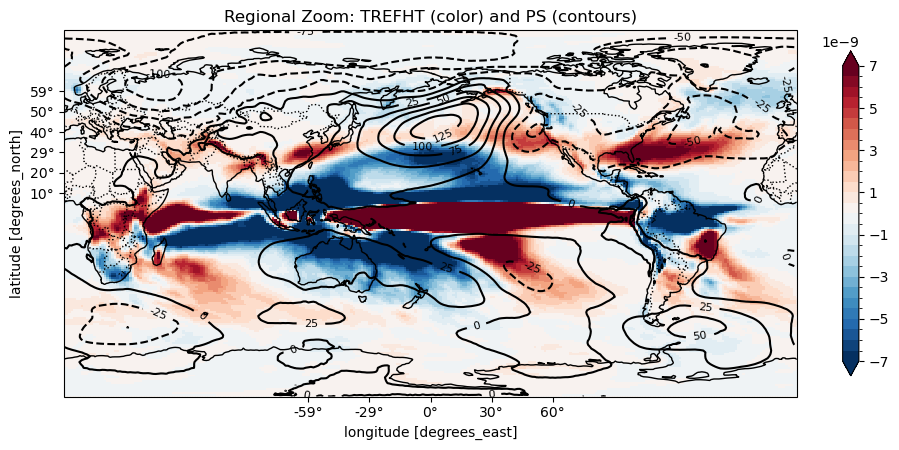

In [21]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Set extent to zoom in on a particular region
# ax.set_extent([120, 300, 10, 80], crs=ccrs.PlateCarree())  # [min_lon, max_lon, min_lat, max_lat]

# Color-filled plot for TREFHT with discrete levels
prect_plot = slopes_diffy['PRECT'].plot(
    ax=ax, 
    transform=ccrs.PlateCarree(), 
    cmap=cmap, 
    norm=norm, 
    add_colorbar=True, 
    cbar_kwargs={'boundaries': levels, 'ticks': fewer_ticks, 'shrink': 0.7}  # Shrink and reduce the number of ticks
)
plt.title('Regional Zoom: TREFHT (color) and PS (contours)')

# Adding contour lines for PS
contour = ax.contour(slopes_diffy['PS']['lon'], slopes_diffy['PS']['lat'], slopes_diffy_DS2['PS']-slopes_diffy['PS'], levels=10, colors='black', transform=ccrs.PlateCarree())
ax.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')

# Adding coastlines and formatting
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_xticks([120, 150, 180, 210, 240], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
ax.set_yticks([10, 20, 30, 40, 50, 60], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))

plt.tight_layout()
plt.show()

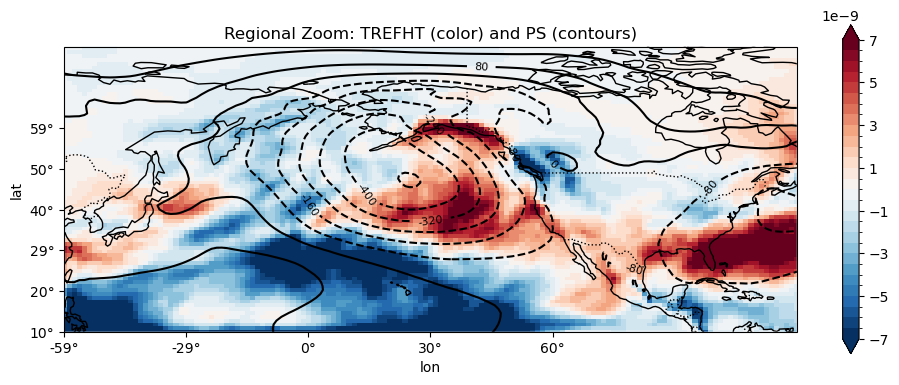

In [176]:
d_da = result_da.rename({'time':'samples'})
slopes_diffy = compute_regression_slopes(d_da.sel(samples=slice(0,100)))
# Assuming your dataset is already loaded and slope_PS and slope_PRECT are calculated
# Replace with the correct path to your dataset
# Define discrete color levels
levels = list(np.arange(-.7, .75, .05) * 1e-8)
cmap = plt.get_cmap('RdBu_r')
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

# Define fewer ticks for the colorbar
fewer_ticks = [-7e-9, -5e-9, -3e-9, -1e-9, 1e-9, 3e-9, 5e-9, 7e-9]  # Select fewer representative levels

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Set extent to zoom in on a particular region
ax.set_extent([120, 300, 10, 80], crs=ccrs.PlateCarree())  # [min_lon, max_lon, min_lat, max_lat]

# Color-filled plot for TREFHT with discrete levels
prect_plot = slopes_diffy['PRECT'].plot(
    ax=ax, 
    transform=ccrs.PlateCarree(), 
    cmap=cmap, 
    norm=norm, 
    add_colorbar=True, 
    cbar_kwargs={'boundaries': levels, 'ticks': fewer_ticks, 'shrink': 0.7}  # Shrink and reduce the number of ticks
)
plt.title('Regional Zoom: TREFHT (color) and PS (contours)')

# Adding contour lines for PS
contour = ax.contour(slopes_diffy['PS']['lon'], slopes_diffy['PS']['lat'], slopes_diffy['PS'], levels=10, colors='black', transform=ccrs.PlateCarree())
ax.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')

# Adding coastlines and formatting
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_xticks([120, 150, 180, 210, 240], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
ax.set_yticks([10, 20, 30, 40, 50, 60], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))

plt.tight_layout()
plt.show()


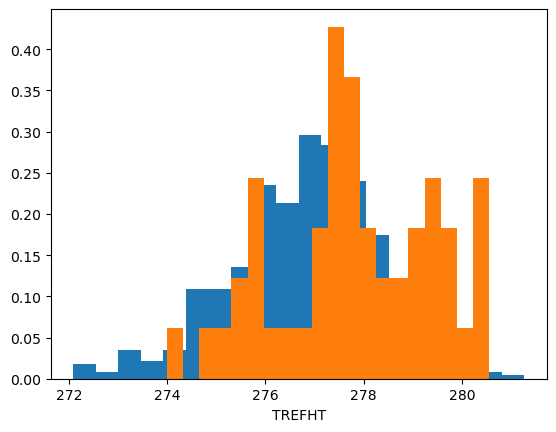

In [177]:
DS1.sel(lat=slice(28,50),lon=slice(230,290))['TREFHT'].mean(['lat','lon']).plot.hist(bins=20,density=True,label='Diff')
d_da.sel(lat=slice(28,50),lon=slice(230,290))['TREFHT'].mean(['lat','lon']).plot.hist(bins=20,density=True,label='lens')
plt.show()

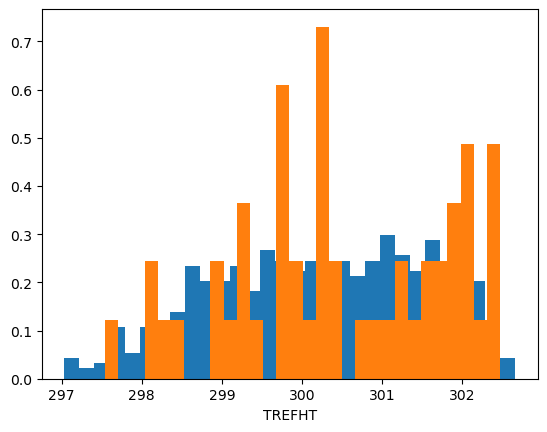

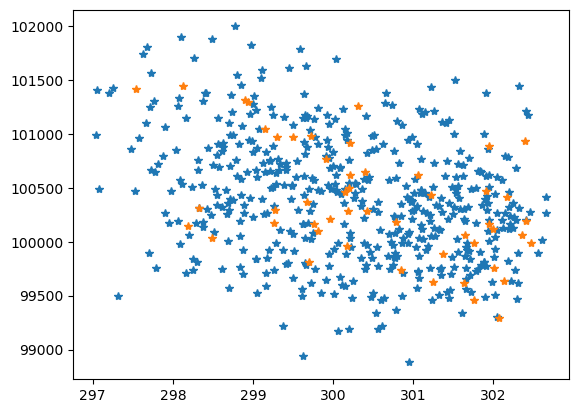

In [180]:
DS1.sel(lat=slice(-5,5),lon=slice(190,240))['TREFHT'].mean(['lat','lon']).plot.hist(bins=30,density=True)
d_da.sel(lat=slice(-5,5),lon=slice(190,240))['TREFHT'].mean(['lat','lon']).plot.hist(bins=30,density=True)
plt.show()
# d_da.sel(lat=slice(28,50),lon=slice(230,290))['TREFHT'].mean(['lat','lon']).plot.hist(bins=20,density=True)
# plt.show()
p1 = DS1.sel(lat=slice(-5,5),lon=slice(190,240))['TREFHT'].mean(['lat','lon'])
p2 = DS1.sel(lat=slice(30,60),lon=slice(150,220))['PS'].mean(['lat','lon'])
p3 = d_da.sel(lat=slice(-5,5),lon=slice(190,240))['TREFHT'].mean(['lat','lon'])
p4 = d_da.sel(lat=slice(30,60),lon=slice(150,220))['PS'].mean(['lat','lon'])
plt.plot(p1,p2,'*')
plt.plot(p3,p4,'*')

In [117]:
# Example usage:
co2vmr = 0.0004421641313381595
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CESM_LE2_vars_BSSP370cmip6/*.001.*.nc'))
# result_da_1 = xr.merge([extract_closest_co2vmr_data(co2vmr, 'TREFHT', FNS),extract_closest_co2vmr_data(co2vmr, 'PRECT', FNS),extract_closest_co2vmr_data(co2vmr, 'PS', FNS)])


## Let's look at the global warming trend

In [88]:
%%time
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/Gen_CESM/samples_governance_indexes_3944_month02*.nc'))
mea_trend = []
std_trend = []
all_mea_trend ={}

lens_mea_trend = []
lens_std_trend = []
all_lens_mea_trend ={}


for ee,fn in enumerate(FNS):
    print('doing:',ee+2015,fn)
    DS = xr.open_dataset(fn)
    lat = DS['lat']
    # Calculate weights: cos(lat) in radians
    weights = np.cos(np.deg2rad(lat))

    tmean = DS['TREFHT'].weighted(weights).mean(dim=['lat', 'lon','samples'])
    mea_trend.append(tmean.values)

    all_mea_trend[ee] = DS['TREFHT'].weighted(weights).mean(dim=['lat', 'lon']).values

    # DDS = xs.resample_iterations_idx(DS['TREFHT'], 50, "samples") 
    # std_trend.append(DDS.sel(samples=slice(0,50)).weighted(weights).mean(dim=['samples','lat','lon']).std('iteration'))

    #now for the LENS:
    #1. find files:
    co2vmr = float(fn.split('co2')[-1].split('_')[0])
    FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CESM_LE2_vars_BSSP370cmip6/*1001.001*.nc'))
    yt, mt, fout = closest_co2vmr_year(co2vmr, FNS)

    if mt != 3:
        print('FUCKKKKK')
    
    FNS_year = sorted(glob.glob(f'/glade/derecho/scratch/wchapman/CESM_LE2_vars_BSSP370cmip6/*.{int(fout.split(".")[-2][:4])}*.nc'))
    results_da1 = extract_closest_co2vmr_data(co2vmr, mt, 'TREFHT', FNS_year)

    tmean_lens = results_da1['TREFHT'].weighted(weights).mean(dim=['lat', 'lon','time'])
    lens_mea_trend.append(tmean_lens.values)

    all_lens_mea_trend[ee] = results_da1['TREFHT'].weighted(weights).mean(dim=['lat', 'lon']).values
    # DDS_lens = xs.resample_iterations_idx(results_da1['TREFHT'], 50, "time") 
    # lens_std_trend.append(DDS_lens.weighted(weights).mean(dim=['time','lat','lon']).std('iteration'))
        

# plt.plot(np.array(mea_trend),'*')
# plt.plot(np.array(mea_trend)+np.array(std_trend),color='r')
# plt.plot(np.array(mea_trend)-np.array(std_trend),color='r')
# plt.show()

doing: 2015 /glade/derecho/scratch/wchapman/Gen_CESM/samples_governance_indexes_3944_month02_co20.0003991389897498876_001.nc
min dist: 0.0
doing: 2016 /glade/derecho/scratch/wchapman/Gen_CESM/samples_governance_indexes_3944_month02_co20.0004020489956418128_001.nc
min dist: 0.0
doing: 2017 /glade/derecho/scratch/wchapman/Gen_CESM/samples_governance_indexes_3944_month02_co20.0004049043903089039_001.nc
min dist: 0.0
doing: 2018 /glade/derecho/scratch/wchapman/Gen_CESM/samples_governance_indexes_3944_month02_co20.00040781448757888313_001.nc
min dist: 0.0
doing: 2019 /glade/derecho/scratch/wchapman/Gen_CESM/samples_governance_indexes_3944_month02_co20.0004108964775733599_001.nc
min dist: 0.0
doing: 2020 /glade/derecho/scratch/wchapman/Gen_CESM/samples_governance_indexes_3944_month02_co20.00041407351246524655_001.nc
min dist: 0.0
doing: 2021 /glade/derecho/scratch/wchapman/Gen_CESM/samples_governance_indexes_3944_month02_co20.0004173469214623615_001.nc
min dist: 0.0
doing: 2022 /glade/derech

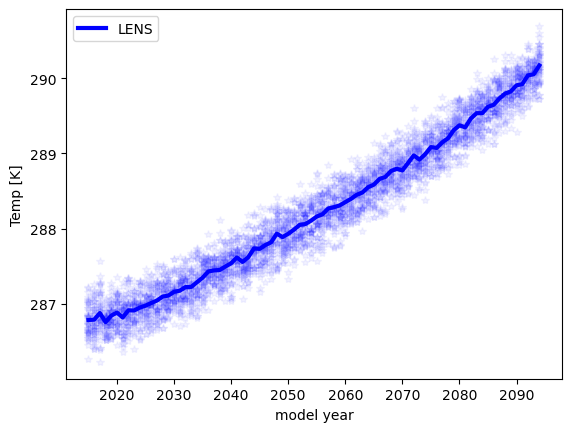

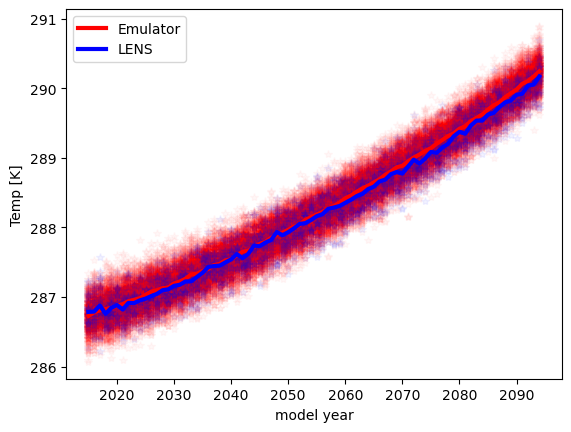

In [96]:

for bb in all_lens_mea_trend.keys():
    plt.plot([2015+bb]*50,all_lens_mea_trend[bb],'*', alpha =0.05,color='b')
plt.plot(np.arange(0,80)+2015,np.array(lens_mea_trend),'b',label='LENS',linewidth=3)
plt.legend()
plt.xlabel('model year')
plt.ylabel('Temp [K]')
plt.show()

for bb in all_mea_trend.keys():
    plt.plot([2015+bb]*500,all_mea_trend[bb],'*', alpha =0.03,color='r')

for bb in all_lens_mea_trend.keys():
    plt.plot([2015+bb]*50,all_lens_mea_trend[bb],'*', alpha =0.05,color='b')
    
plt.plot(np.arange(0,80)+2015,np.array(mea_trend),'r',label='Emulator',linewidth=3)
plt.plot(np.arange(0,80)+2015,np.array(lens_mea_trend),'b',label='LENS',linewidth=3)
plt.xlabel('model year')
plt.ylabel('Temp [K]')
plt.legend()
plt.show()

## Lets see how ENSO is Changing

In [21]:
fn = '/glade/derecho/scratch/wchapman/Gen_CESM/samples_governance_indexes_3944_month02_co20.0003991389897498876_001.nc'
DS1 = xr.open_dataset(fn)
slopes_diffy_early = compute_regression_slopes(DS1.sel(samples=slice(0,500)))

#now lens: 
co2vmr = float(fn.split('co2')[-1].split('_')[0])
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CESM_LE2_vars_BSSP370cmip6/*1001.001*.nc'))
yt, mt, fout = closest_co2vmr_year(co2vmr, FNS)
if mt != 3:
    print('FUCKKKKK')
FNS_year = sorted(glob.glob(f'/glade/derecho/scratch/wchapman/CESM_LE2_vars_BSSP370cmip6/*.{int(fout.split(".")[-2][:4])}*.nc'))
results_da1 = extract_closest_co2vmr_data(co2vmr, mt, 'TREFHT', FNS_year)
results_da2 = extract_closest_co2vmr_data(co2vmr, mt, 'PRECT', FNS_year)
results_da3 = extract_closest_co2vmr_data(co2vmr, mt, 'PS', FNS_year)
results_da = xr.merge([results_da1,results_da2,results_da3])
slopes_diffy_lens_early = compute_regression_slopes(results_da.sel(time=slice(0,50)).rename({'time':'samples'}))

fn = '/glade/derecho/scratch/wchapman/Gen_CESM/samples_governance_indexes_3944_month02_co20.0008078760660432074_001.nc'
DS1 = xr.open_dataset(fn)
slopes_diffy_late = compute_regression_slopes(DS1.sel(samples=slice(0,500)))

#now lens: 
co2vmr = float(fn.split('co2')[-1].split('_')[0])
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CESM_LE2_vars_BSSP370cmip6/*1001.001*.nc'))
yt, mt, fout = closest_co2vmr_year(co2vmr, FNS)
if mt != 3:
    print('FUCKKKKK')
FNS_year = sorted(glob.glob(f'/glade/derecho/scratch/wchapman/CESM_LE2_vars_BSSP370cmip6/*.{int(fout.split(".")[-2][:4])}*.nc'))
results_da1 = extract_closest_co2vmr_data(co2vmr, mt, 'TREFHT', FNS_year)
results_da2 = extract_closest_co2vmr_data(co2vmr, mt, 'PRECT', FNS_year)
results_da3 = extract_closest_co2vmr_data(co2vmr, mt, 'PS', FNS_year)
results_da = xr.merge([results_da1,results_da2,results_da3])
slopes_diffy_lens_late = compute_regression_slopes(results_da.sel(time=slice(0,50)).rename({'time':'samples'}))

min dist: 0.0
min dist: 0.0003773056246557157
min dist: 0.00033841850515136057
min dist: 0.0002939590399651085
min dist: 0.00024424763619644585
min dist: 0.0001891211805903441
min dist: 0.00012808888050255503
min dist: 6.065586795520072e-05
min dist: 0.0


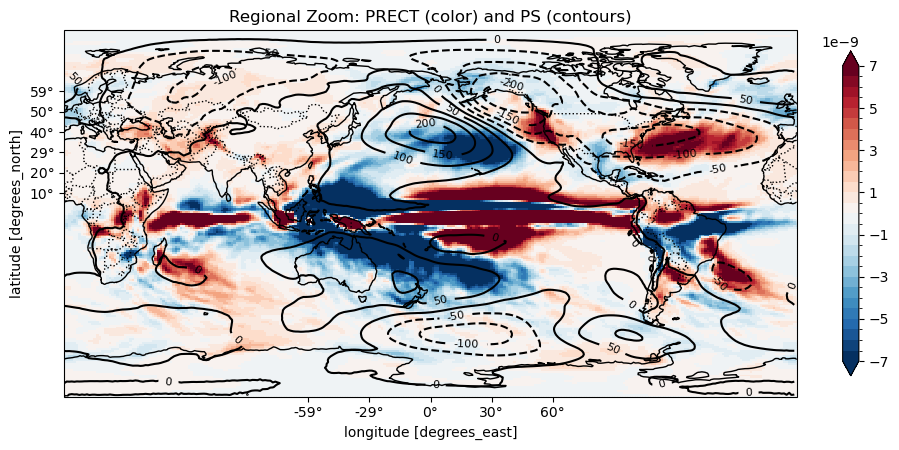

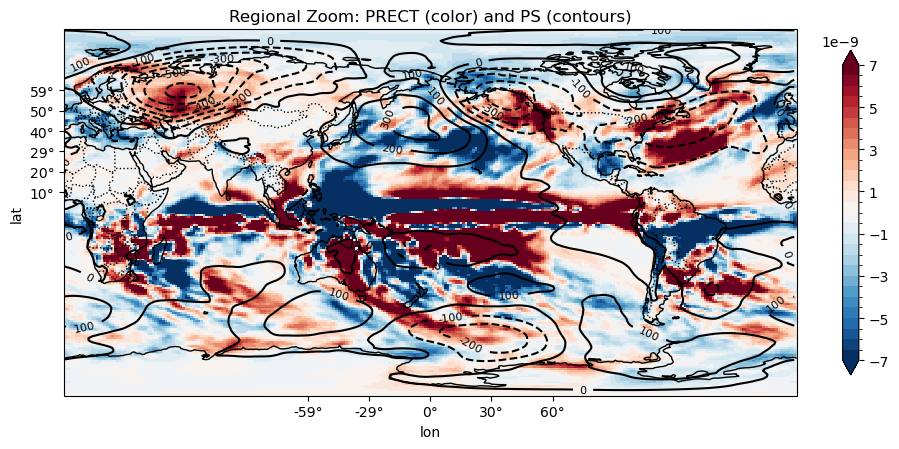

In [37]:
plot_ENSO_NA_diff(slopes_diffy_late, slopes_diffy_early)
plot_ENSO_NA_diff(slopes_diffy_lens_late, slopes_diffy_lens_early)

In [36]:
def plot_ENSO_NA_diff(slopes_diffy1, slopes_diffy2):
    levels = list(np.arange(-.7, .75, .05) * 1e-8)
    cmap = plt.get_cmap('RdBu_r')
    norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
    
    # Define fewer ticks for the colorbar
    fewer_ticks = [-7e-9, -5e-9, -3e-9, -1e-9, 1e-9, 3e-9, 5e-9, 7e-9]  # Select fewer representative levels
    
    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    
    # Set extent to zoom in on a particular region
    # ax.set_extent([120, 300, -10, 80], crs=ccrs.PlateCarree())  # [min_lon, max_lon, min_lat, max_lat]
    
    # Color-filled plot for TREFHT with discrete levels
    prect_plot = (slopes_diffy1['PRECT']-slopes_diffy2['PRECT']).plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap=cmap, 
        norm=norm, 
        add_colorbar=True, 
        cbar_kwargs={'boundaries': levels, 'ticks': fewer_ticks, 'shrink': 0.7}  # Shrink and reduce the number of ticks
    )
    plt.title('Regional Zoom: PRECT (color) and PS (contours)')
    
    # Adding contour lines for PS
    contour = ax.contour(slopes_diffy1['PS']['lon'], slopes_diffy1['PS']['lat'], slopes_diffy1['PS']-slopes_diffy2['PS'], levels=10, colors='black', transform=ccrs.PlateCarree())
    ax.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')
    
    # Adding coastlines and formatting
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_xticks([120, 150, 180, 210, 240], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
    ax.set_yticks([10, 20, 30, 40, 50, 60], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))
    
    plt.tight_layout()
    plt.show()

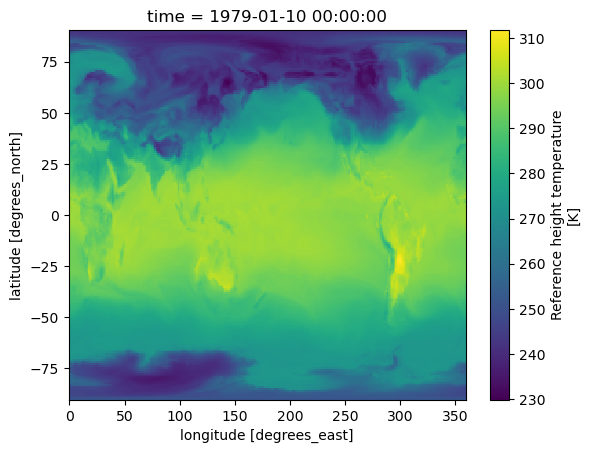

In [86]:
DDOND = xr.open_dataset('/glade/derecho/scratch/wchapman/test_gather/f.e21.CREDIT_climate.cam.h1.1979-01-10-00000_processed.nc')
# DDOND['Q'].sel(level = 1000, method='nearest').isel(time=0).plot()
DDOND['TREFHT'].isel(time=0).plot()

In [8]:
tmean = DS['TREFHT'].weighted(weights).mean(dim=['lat', 'lon','samples'])
mea_trend.append(tmean.values)
DDS = xs.resample_iterations_idx(DS['TREFHT'], 50, "samples") 

In [17]:
DDS.sel(samples=slice(0,50)).weighted(weights).mean(dim=['samples','lat','lon'])

<xarray.DataArray (iteration: 50)> Size: 400B
array([286.72735623, 286.79110876, 286.71572671, 286.71213791,
       286.7431541 , 286.69826994, 286.71960909, 286.75713713,
       286.77280007, 286.75586261, 286.68857563, 286.692115  ,
       286.74767896, 286.76360089, 286.69541592, 286.72179889,
       286.6813203 , 286.71021643, 286.76084686, 286.73100437,
       286.74857894, 286.69314953, 286.71338033, 286.70736167,
       286.7521256 , 286.72317063, 286.72160847, 286.70316542,
       286.69403239, 286.69805019, 286.74217504, 286.7203651 ,
       286.74239301, 286.77152876, 286.76296826, 286.75636464,
       286.78763863, 286.72295812, 286.74640557, 286.70719592,
       286.69145846, 286.73175735, 286.71488175, 286.74279264,
       286.7238983 , 286.72493785, 286.70890589, 286.70472077,
       286.71636462, 286.7096638 ])
Coordinates:
  * iteration  (iteration) int64 400B 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49

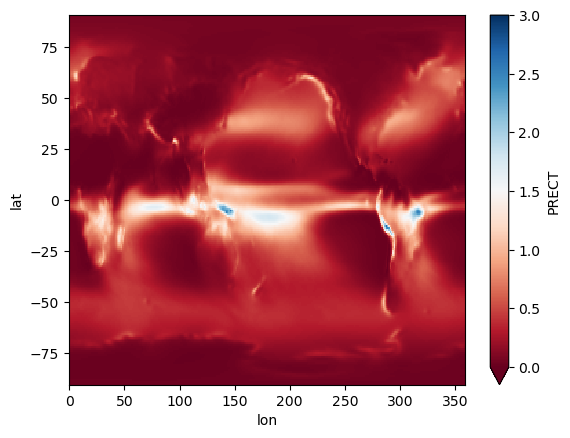

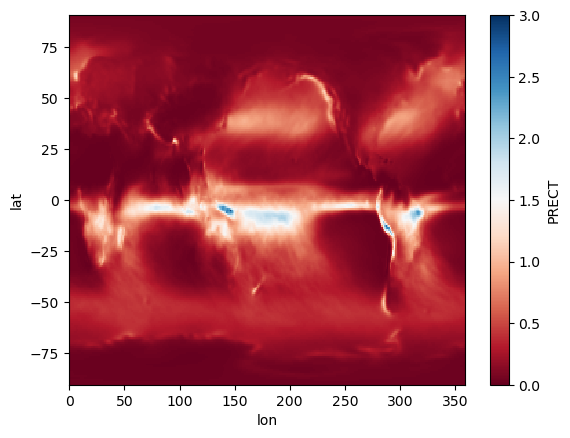

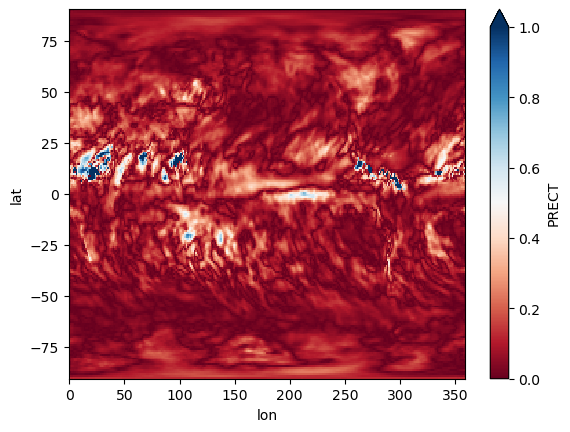

In [199]:
# results_da1 = extract_closest_co2vmr_data(co2vmr, mt, 'PRECT', FNS_year)
oner = DS['PRECT'].isel(samples=slice(0,500)).mean('samples')*10000000
twoer = results_da1['PRECT'].mean('time')*10000000
threeer = np.abs((oner - twoer) / oner)

(oner).plot(cmap='RdBu',vmin=0,vmax=3)
plt.show()

(twoer).plot(cmap='RdBu',vmin=0,vmax=3)
plt.show()

(threeer).plot(cmap='RdBu',vmin=0,vmax=1)
plt.show()

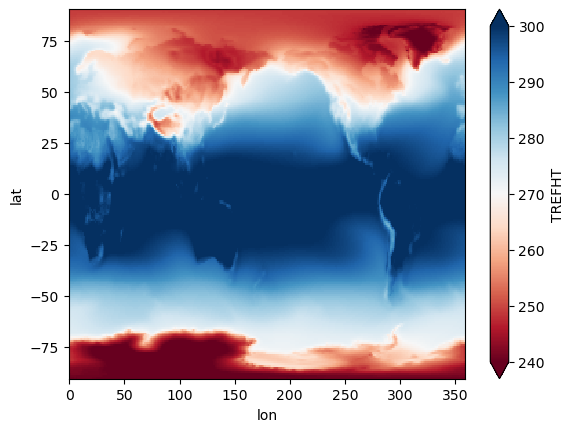

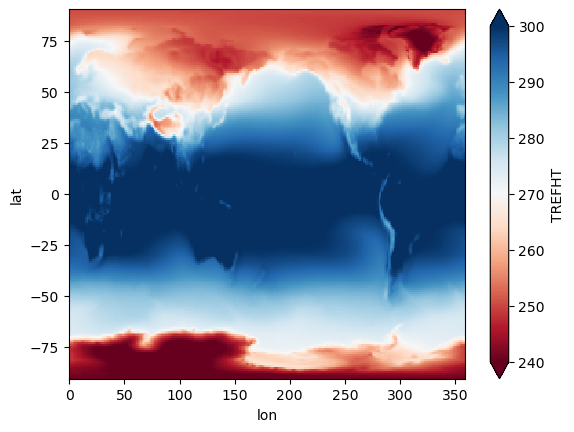

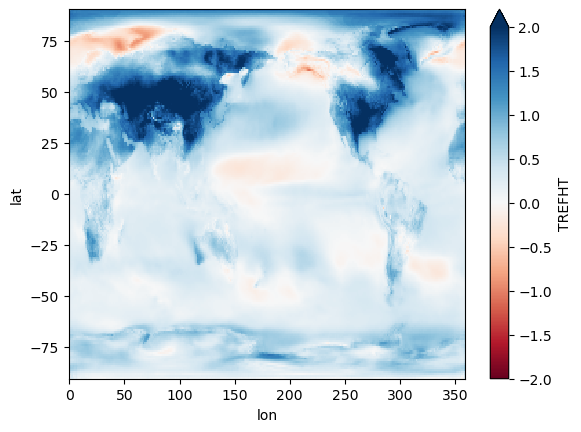

In [191]:
# results_da1 = extract_closest_co2vmr_data(co2vmr, mt, 'TREFHT', FNS_year)
(DS['TREFHT'].isel(samples=slice(0,50)).mean('samples')).plot(cmap='RdBu',vmin=240,vmax=300)
plt.show()
(results_da1['TREFHT'].mean('time')).plot(cmap='RdBu',vmin=240,vmax=300)
plt.show()


(results_da1['TREFHT'].mean('time') - DS['TREFHT'].isel(samples=slice(0,50)).mean('samples')).plot(cmap='RdBu',vmin=-2,vmax=2)
plt.show()

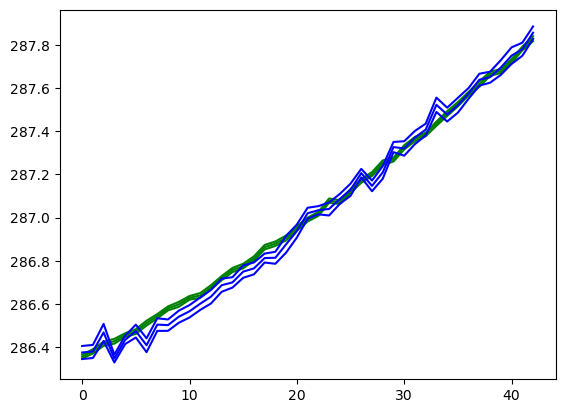

In [148]:
plt.plot(np.array(mea_trend),'g')
plt.plot(np.array(mea_trend)+np.array(std_trend),color='g')
plt.plot(np.array(mea_trend)-np.array(std_trend),color='g')

plt.plot(np.array(lens_mea_trend)-.41,'b')
plt.plot(np.array(lens_mea_trend)-.41+np.array(lens_std_trend),color='b')
plt.plot(np.array(lens_mea_trend)-.41-np.array(lens_std_trend),color='b')
plt.show()
plt.show()

In [155]:
with open('../scaling/scaling_dict_CC.pkl', 'rb') as file:
    loaded_mean_std_dict = pickle.load(file)

with open('../scaling/scaling_dict.pkl', 'rb') as file:
    loaded_mean_std_dict_old = pickle.load(file)
        
with open('../scaling/scaling_dict_minmax_CC.pkl', 'rb') as file:
    loaded_min_max_dict = pickle.load(file)


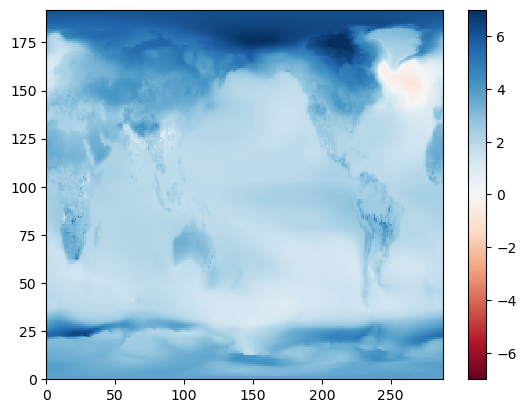

In [162]:
plt.pcolor(loaded_mean_std_dict['TREFHT_mean']-loaded_mean_std_dict_old['TREFHT_mean'],vmin=-7,vmax=7,cmap='RdBu')
plt.colorbar()
plt.show()

In [ ]:
#now for the LENS:
#1. find files:
co2vmr = 0.0004020489956418128
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CESM_LE2_vars_BSSP370cmip6/*1001.001*.nc'))
yt, mt, fout = closest_co2vmr_year(co2vmr, FNS)
if mt != 3:
    print('FUCKKKKK')
FNS_year = sorted(glob.glob(f'/glade/derecho/scratch/wchapman/CESM_LE2_vars_BSSP370cmip6/*.{int(fout.split(".")[-2][:4])}*.nc'))
results_da1 = extract_closest_co2vmr_data(co2vmr, mt, 'TREFHT', FNS_year)

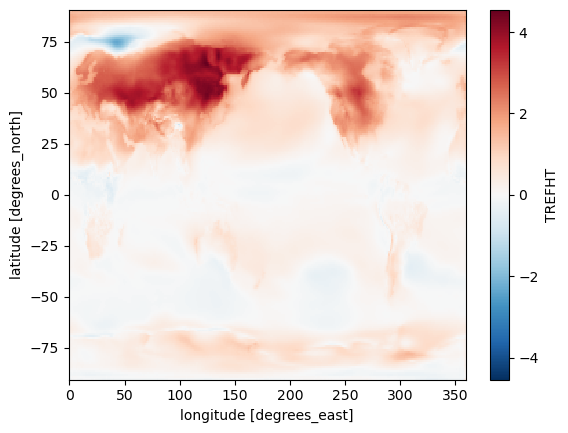

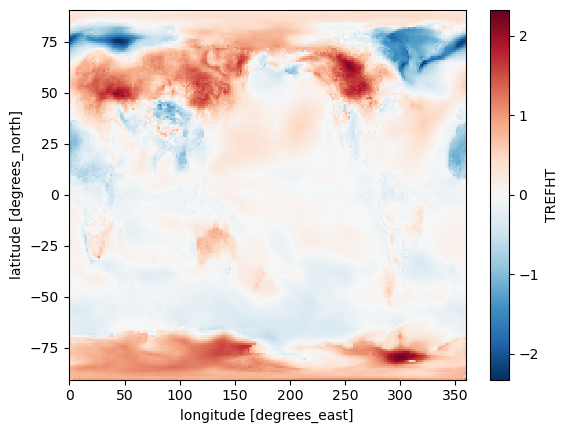

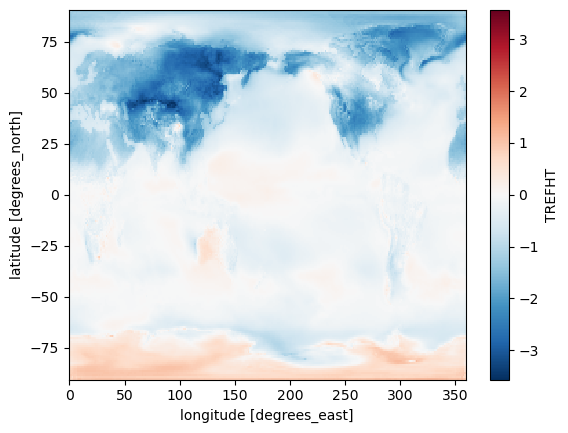

In [217]:
DS1 = xr.open_dataset('/glade/derecho/scratch/wchapman/Gen_CESM/samples_toyota_estates_037_month02_co20.0004020489956418128_001.nc')
DS2 = xr.open_dataset('/glade/derecho/scratch/wchapman/Gen_CESM/samples_toyota_estates_month02_co20.0004020489956418128_001.nc')
(DS1['TREFHT'].mean('samples')-DS2['TREFHT'].mean('samples')).plot()
plt.show()
DSlens = results_da1['TREFHT'].mean('time')
(DS1['TREFHT'].mean('samples')-DSlens).plot()
plt.show()

(DS2['TREFHT'].mean('samples')-DSlens).plot()
plt.show()
# samples_toyota_estates_month02_co20.0004020489956418128_001.nc

## Grab the LENS

In [7]:
# Example usage:
# Specify the month you want to extract (e.g., 2 for February)
month_get = mo_lens
file_pattern = '/glade/derecho/scratch/wchapman/CESM_LE2_vars_with_climo/*.nc'

# Call the function to concatenate datasets
DS_lens = concat_files_by_month(month_get, file_pattern)

# Optionally, save the concatenated dataset to a new NetCDF file
# DS_concat.to_netcdf('/path/to/save/concatenated_feb_samples.nc')

# Print the concatenated dataset for confirmation
print(DS_lens)


<xarray.Dataset> Size: 1GB
Dimensions:   (samples: 1650, lat: 192, lon: 288)
Coordinates:
  * lat       (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * samples   (samples) int64 13kB 0 1 2 3 4 5 ... 1644 1645 1646 1647 1648 1649
Data variables:
    PS        (samples, lat, lon) float32 365MB 6.873e+04 ... 1.006e+05
    PRECT     (samples, lat, lon) float32 365MB 2.068e-09 2.068e-09 ... 4.78e-09
    TREFHT    (samples, lat, lon) float32 365MB 245.5 245.5 ... 253.7 253.7
    CLIM_T2M  (samples, lat, lon) float32 365MB 245.3 245.3 ... 245.4 245.4
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BHISTcmip6.f09_g17.LE2-1001.001
    logname:           sunseon
    host:              mom1
    initial_file:      b.e21.B1850.f09_g17.CMIP6-piControl.001.cam.i.1001-01-...
    topography_file:   /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/fv_0.9x...

In [8]:
slopes_lens = compute_regression_slopes(DS_lens.sel(samples=slice(0,1000)))
# You can access the slope maps for each variable, for example:
slope_PS_lens = slopes_lens['PS']
slope_PRECT_lens = slopes_lens['PRECT']
slope_TREFHT_lens = slopes_lens['TREFHT']

# Call the function to compute slopes
slopes = compute_regression_slopes(DS.sel(samples=slice(0,1000)))
# You can access the slope maps for each variable, for example:
slope_PS = slopes['PS']
slope_PRECT = slopes['PRECT']
slope_TREFHT = slopes['TREFHT']


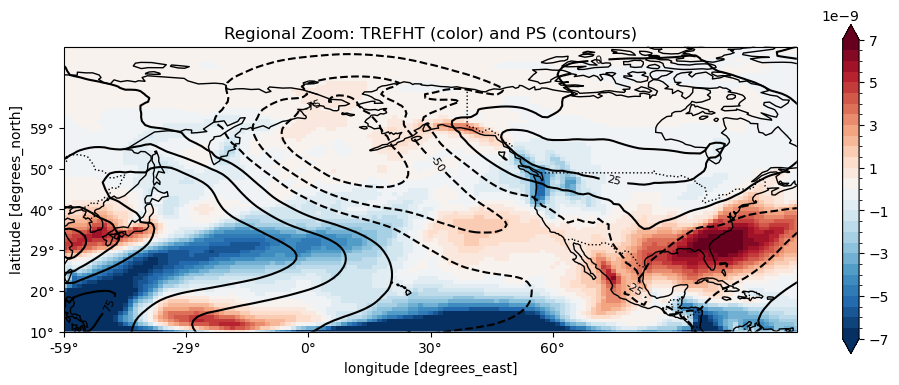

In [9]:

# Assuming your dataset is already loaded and slope_PS and slope_PRECT are calculated
# Replace with the correct path to your dataset
# Define discrete color levels
levels = list(np.arange(-.7, .75, .05) * 1e-8)
cmap = plt.get_cmap('RdBu_r')
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

# Define fewer ticks for the colorbar
fewer_ticks = [-7e-9, -5e-9, -3e-9, -1e-9, 1e-9, 3e-9, 5e-9, 7e-9]  # Select fewer representative levels

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Set extent to zoom in on a particular region
ax.set_extent([120, 300, 10, 80], crs=ccrs.PlateCarree())  # [min_lon, max_lon, min_lat, max_lat]

# Color-filled plot for TREFHT with discrete levels
prect_plot = slope_PRECT_lens.plot(
    ax=ax, 
    transform=ccrs.PlateCarree(), 
    cmap=cmap, 
    norm=norm, 
    add_colorbar=True, 
    cbar_kwargs={'boundaries': levels, 'ticks': fewer_ticks, 'shrink': 0.7}  # Shrink and reduce the number of ticks
)
plt.title('Regional Zoom: TREFHT (color) and PS (contours)')

# Adding contour lines for PS
contour = ax.contour(slope_PS_lens['lon'], slope_PS_lens['lat'], slope_PS_lens, levels=10, colors='black', transform=ccrs.PlateCarree())
ax.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')

# Adding coastlines and formatting
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_xticks([120, 150, 180, 210, 240], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
ax.set_yticks([10, 20, 30, 40, 50, 60], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))

plt.tight_layout()
plt.show()


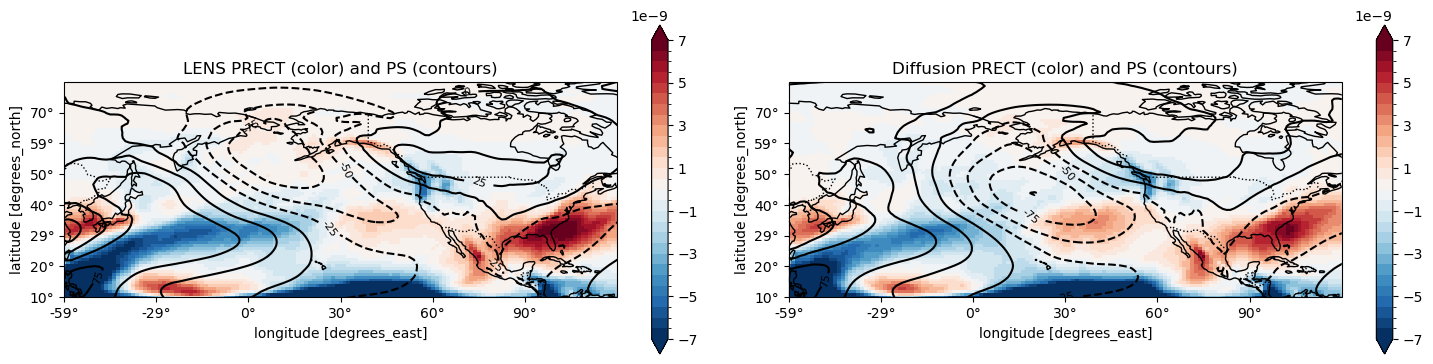

In [10]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.colors as mcolors

# Assuming slope_PS_lens, slope_PS, slope_PRECT_lens, slope_PRECT are calculated

# Define discrete color levels
levels = list(np.arange(-.7, .75, .05) * 1e-8)
cmap = plt.get_cmap('RdBu_r')
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

# Define fewer ticks for the colorbar
fewer_ticks = [-7e-9, -5e-9, -3e-9, -1e-9, 1e-9, 3e-9, 5e-9, 7e-9]

# Plotting with two panels
fig, axs = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Set extent for zoomed region
extent = [120, 300, 10, 80]  # [min_lon, max_lon, min_lat, max_lat]

# Panel 1: PRECT_lens
axs[0].set_extent(extent, crs=ccrs.PlateCarree())
prect_plot = slope_PRECT_lens.plot(
    ax=axs[0],
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    add_colorbar=True,
    cbar_kwargs={'boundaries': levels, 'ticks': fewer_ticks, 'shrink': 0.7}
)
axs[0].set_title('LENS PRECT (color) and PS (contours)')
contour_lens = axs[0].contour(slope_PS_lens['lon'], slope_PS_lens['lat'], slope_PS_lens, levels=10, colors='black', transform=ccrs.PlateCarree())
axs[0].clabel(contour_lens, inline=True, fontsize=8, fmt='%1.0f')

# Add coastlines, borders, and tick labels for Panel 1
axs[0].coastlines()
axs[0].add_feature(cfeature.BORDERS, linestyle=':')
axs[0].set_xticks([120, 150, 180, 210, 240, 270], crs=ccrs.PlateCarree())
axs[0].set_yticks([10, 20, 30, 40, 50, 60, 70], crs=ccrs.PlateCarree())
axs[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))

# Panel 2: PRECT
axs[1].set_extent(extent, crs=ccrs.PlateCarree())
prect_plot = slope_PRECT.plot(
    ax=axs[1],
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    add_colorbar=True,
    cbar_kwargs={'boundaries': levels, 'ticks': fewer_ticks, 'shrink': 0.7}
)
axs[1].set_title('Diffusion PRECT (color) and PS (contours)')
contour = axs[1].contour(slope_PS['lon'], slope_PS['lat'], slope_PS, levels=10, colors='black', transform=ccrs.PlateCarree())
axs[1].clabel(contour, inline=True, fontsize=8, fmt='%1.0f')

# Add coastlines, borders, and tick labels for Panel 2
axs[1].coastlines()
axs[1].add_feature(cfeature.BORDERS, linestyle=':')
axs[1].set_xticks([120, 150, 180, 210, 240, 270], crs=ccrs.PlateCarree())
axs[1].set_yticks([10, 20, 30, 40, 50, 60, 70], crs=ccrs.PlateCarree())
axs[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
axs[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))

plt.tight_layout()
plt.show()


/glade/derecho/scratch/wchapman/tmp/ipykernel_187384/108193656.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


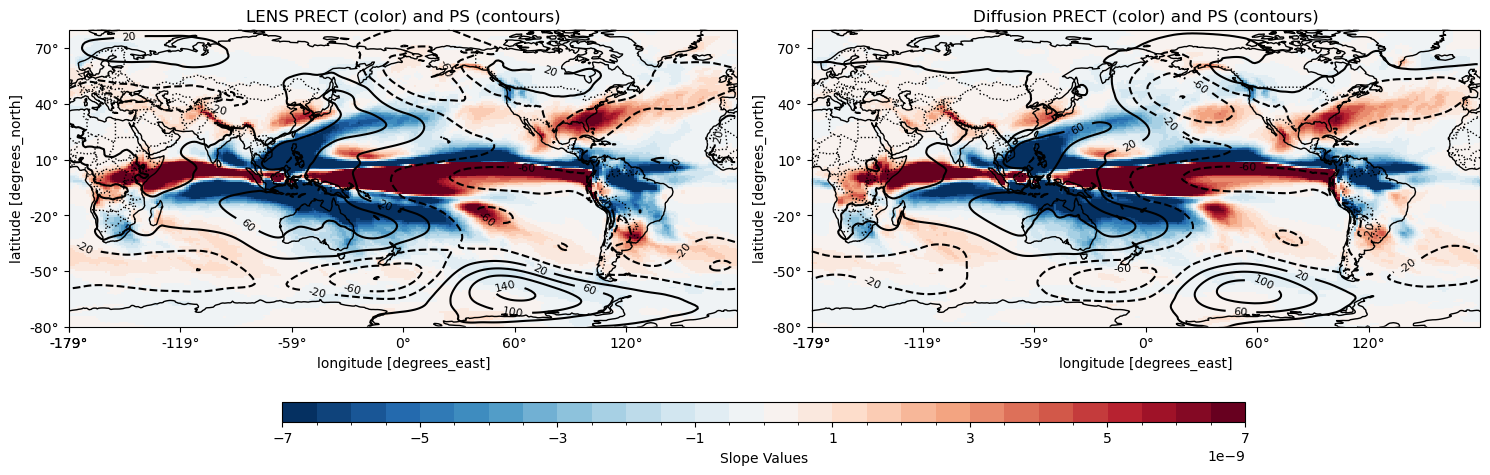

In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.colors as mcolors

# Assuming slope_PS_lens, slope_PS, slope_PRECT_lens, slope_PRECT are calculated

# Define discrete color levels
levels = list(np.arange(-.7, .75, .05) * 1e-8)
cmap = plt.get_cmap('RdBu_r')
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

# Define fewer ticks for the colorbar
fewer_ticks = [-7e-9, -5e-9, -3e-9, -1e-9, 1e-9, 3e-9, 5e-9, 7e-9]

# Standardized contour levels for both PS datasets
contour_levels = np.linspace(-300, 300, 16)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Set extent for both panels (same zoomed region)
extent = [0, 360, -80, 80]  # [min_lon, max_lon, min_lat, max_lat]

# Panel 1: PRECT_lens
axs[0].set_extent(extent, crs=ccrs.PlateCarree())
prect_plot = slope_PRECT_lens.plot(
    ax=axs[0],
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    add_colorbar=False  # We'll add a single colorbar later
)
axs[0].set_title('LENS PRECT (color) and PS (contours)')
contour_lens = axs[0].contour(slope_PS_lens['lon'], slope_PS_lens['lat'], slope_PS_lens, levels=contour_levels, colors='black', transform=ccrs.PlateCarree())
axs[0].clabel(contour_lens, inline=True, fontsize=8, fmt='%1.0f')

# Add coastlines, borders, and tick labels for Panel 1
axs[0].coastlines()
axs[0].add_feature(cfeature.BORDERS, linestyle=':')
axs[0].set_xticks(np.arange(0, 361, 60), crs=ccrs.PlateCarree())
axs[0].set_yticks(np.arange(-80, 81, 30), crs=ccrs.PlateCarree())
axs[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))

# Panel 2: PRECT
axs[1].set_extent(extent, crs=ccrs.PlateCarree())
prect_plot = slope_PRECT.plot(
    ax=axs[1],
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    add_colorbar=False  # We'll add a single colorbar later
)
axs[1].set_title('Diffusion PRECT (color) and PS (contours)')
contour = axs[1].contour(slope_PS['lon'], slope_PS['lat'], slope_PS, levels=contour_levels, colors='black', transform=ccrs.PlateCarree())
axs[1].clabel(contour, inline=True, fontsize=8, fmt='%1.0f')

# Add coastlines, borders, and tick labels for Panel 2
axs[1].coastlines()
axs[1].add_feature(cfeature.BORDERS, linestyle=':')
axs[1].set_xticks(np.arange(0, 361, 60), crs=ccrs.PlateCarree())
axs[1].set_yticks(np.arange(-80, 81, 30), crs=ccrs.PlateCarree())
axs[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
axs[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))

# Add a single shared horizontal colorbar for both panels
cbar = fig.colorbar(prect_plot, ax=axs, orientation='horizontal', fraction=0.05, pad=0.2, aspect=50, ticks=fewer_ticks)
cbar.set_label('Slope Values')

plt.tight_layout()
plt.subplots_adjust(bottom=0.3)  # Adjust the bottom of the figure to fit the colorbar nicely
plt.show()

/glade/derecho/scratch/wchapman/tmp/ipykernel_187384/2924380607.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


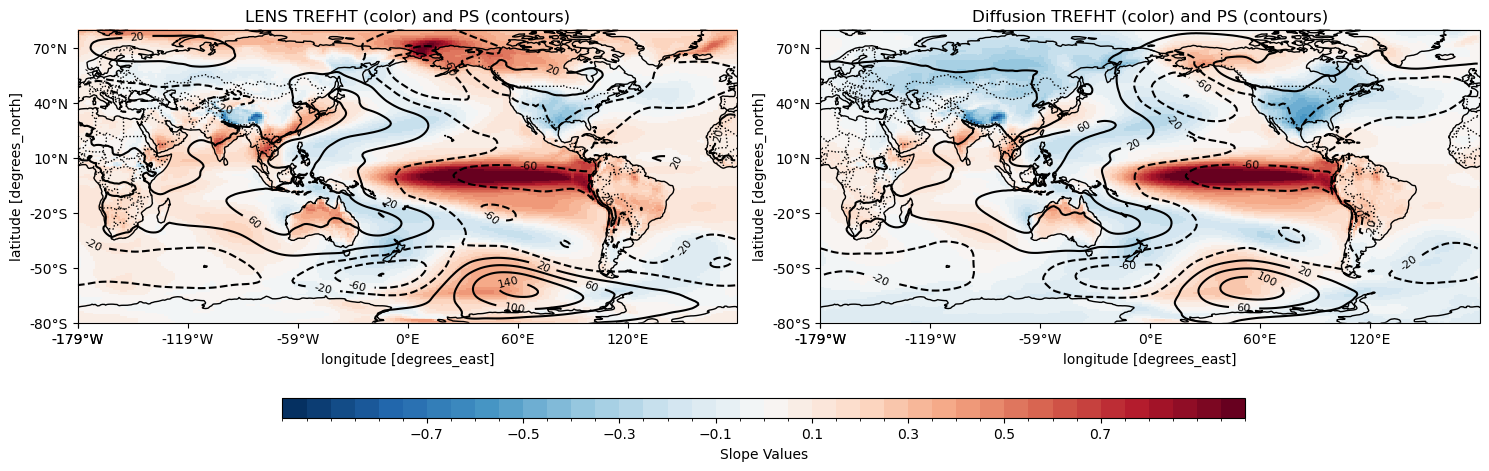

In [12]:
# Assuming slope_PS_lens, slope_PS, slope_TREFHT_lens, slope_TREFHT are calculated

# Define discrete color levels
levels = list(np.arange(-1., 1.05, .05))
cmap = plt.get_cmap('RdBu_r')
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

# Define fewer ticks for the colorbar
fewer_ticks = [-.7, -.5, -.3, -.1, .1, .3, .5, .7]

# Standardized contour levels for both PS datasets
contour_levels = np.linspace(-300, 300, 16)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Set extent for both panels (same zoomed region)
extent = [0, 360, -80, 80]  # [min_lon, max_lon, min_lat, max_lat]

# Panel 1: PRECT_lens
axs[0].set_extent(extent, crs=ccrs.PlateCarree())
prect_plot = slope_TREFHT_lens.plot(
    ax=axs[0],
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    add_colorbar=False  # We'll add a single colorbar later
)
axs[0].set_title('LENS TREFHT (color) and PS (contours)')
contour_lens = axs[0].contour(slope_PS_lens['lon'], slope_PS_lens['lat'], slope_PS_lens, levels=contour_levels, colors='black', transform=ccrs.PlateCarree())
axs[0].clabel(contour_lens, inline=True, fontsize=8, fmt='%1.0f')

# Add coastlines, borders, and tick labels for Panel 1
axs[0].coastlines()
axs[0].add_feature(cfeature.BORDERS, linestyle=':')
axs[0].set_xticks(np.arange(0, 361, 60), crs=ccrs.PlateCarree())
axs[0].set_yticks(np.arange(-80, 81, 30), crs=ccrs.PlateCarree())
axs[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°E' if x > 0 else f'{int(x)}°W'))
axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°N' if y > 0 else f'{int(y)}°S'))

# Panel 2: PRECT
axs[1].set_extent(extent, crs=ccrs.PlateCarree())
prect_plot = slope_TREFHT.plot(
    ax=axs[1],
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    add_colorbar=False  # We'll add a single colorbar later
)
axs[1].set_title('Diffusion TREFHT (color) and PS (contours)')
contour = axs[1].contour(slope_PS['lon'], slope_PS['lat'], slope_PS, levels=contour_levels, colors='black', transform=ccrs.PlateCarree())
axs[1].clabel(contour, inline=True, fontsize=8, fmt='%1.0f')

# Add coastlines, borders, and tick labels for Panel 2
axs[1].coastlines()
axs[1].add_feature(cfeature.BORDERS, linestyle=':')
axs[1].set_xticks(np.arange(0, 361, 60), crs=ccrs.PlateCarree())
axs[1].set_yticks(np.arange(-80, 81, 30), crs=ccrs.PlateCarree())
axs[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°E' if x > 0 else f'{int(x)}°W'))
axs[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°N' if y > 0 else f'{int(y)}°S'))

# Add a single shared horizontal colorbar for both panels
cbar = fig.colorbar(prect_plot, ax=axs, orientation='horizontal', fraction=0.05, pad=0.2, aspect=50, ticks=fewer_ticks)
cbar.set_label('Slope Values')

plt.tight_layout()
plt.subplots_adjust(bottom=0.3)  # Adjust the bottom of the figure to fit the colorbar nicely
plt.show()


## EOFS?

In [16]:
from eofs.xarray import Eof

/glade/derecho/scratch/wchapman/tmp/ipykernel_187384/2677888201.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


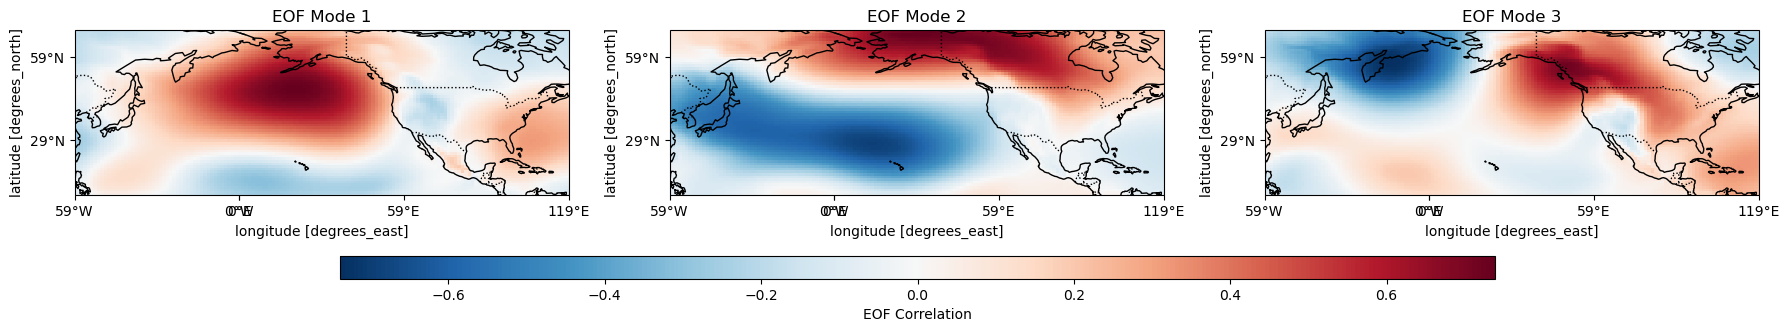

In [61]:
# Assuming PS is already calculated from the dataset DS_lens
PS = DS_lens['PS'].sel(lat=slice(0, 70), lon=slice(120, 300))
PS = PS.rename({'samples': 'time'})

# Calculate weights based on cosine of latitude
coslat = np.cos(np.deg2rad(PS.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]

# Perform EOF analysis
solver1 = Eof(PS, weights=wgts)
eof1 = solver1.eofsAsCorrelation(neofs=3)  # Get the first 3 EOFs
pc1 = solver1.pcs(npcs=3, pcscaling=1)

# Create a figure with three subplots for the first three EOF modes
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Define longitude and latitude ticks (global)
lon_ticks = np.arange(-180, 181, 60)
lat_ticks = np.arange(-90, 91, 30)
extent = [120, 300, 10, 70]  # [min_lon, max_lon, min_lat, max_lat]

# Define common properties for all subplots
for i in range(3):
    eof_mode = eof1.sel(mode=i).squeeze()
    ax = axs[i]

    # Plot each EOF mode
    plot = eof_mode.plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap='RdBu_r', 
        add_colorbar=False  # We will add a single colorbar later
    )

    # Set titles for each mode
    ax.set_title(f'EOF Mode {i+1}')

    # Add coastlines and borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Set longitude and latitude ticks
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

    # Format tick labels
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°E' if x > 0 else (f'{int(abs(x))}°W' if x < 0 else f'{int(x)}°')))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°N' if y > 0 else (f'{int(abs(y))}°S' if y < 0 else f'{int(y)}°')))
    ax.set_extent(extent, crs=ccrs.PlateCarree())


# Add a single colorbar for all subplots
cbar = fig.colorbar(plot, ax=axs, orientation='horizontal', fraction=0.05, pad=0.04, aspect=50)
cbar.set_label('EOF Correlation')

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjust the bottom of the figure to fit the colorbar nicely
plt.show()

/glade/derecho/scratch/wchapman/tmp/ipykernel_187384/3736123211.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


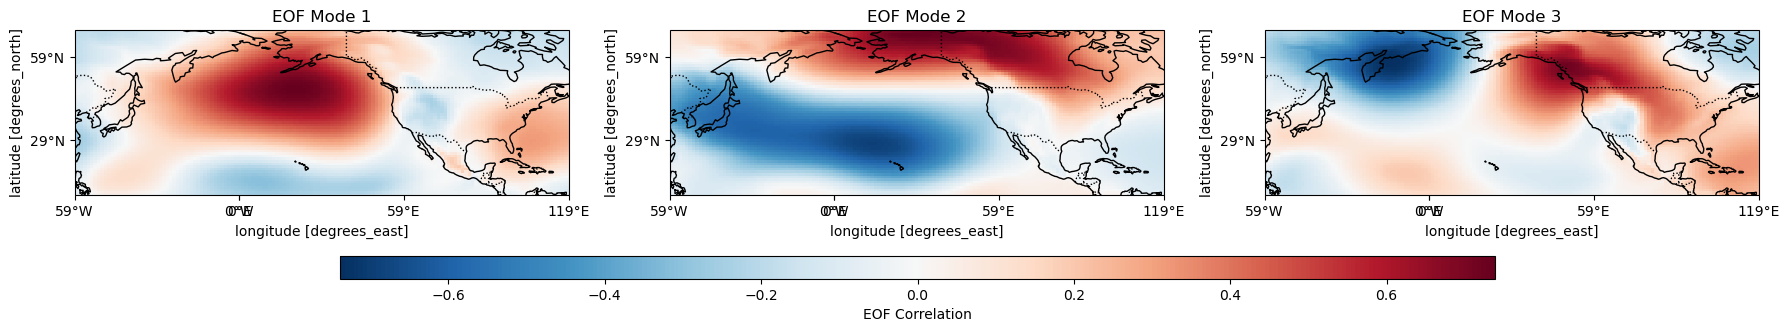

/glade/derecho/scratch/wchapman/tmp/ipykernel_187384/3736123211.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


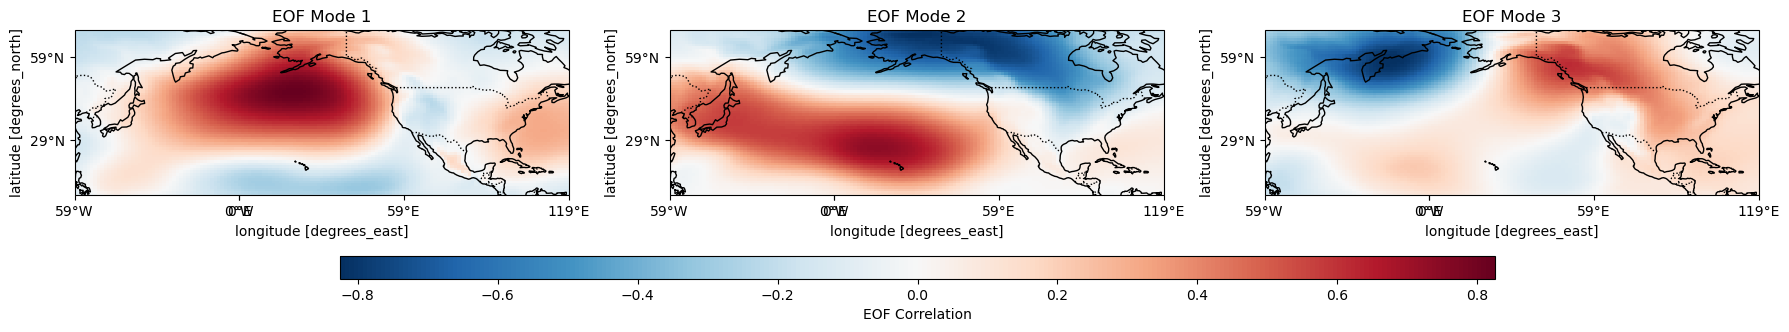

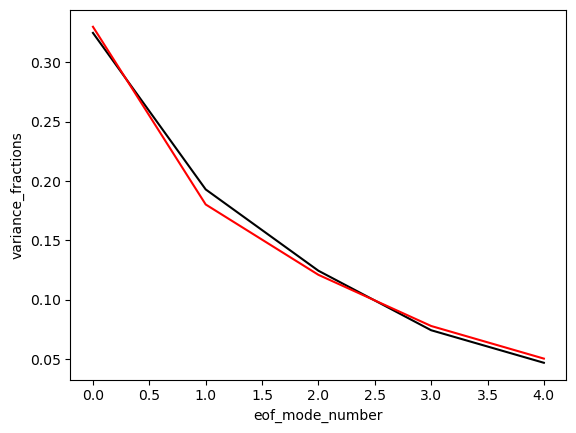

In [64]:
# Assuming PS is already calculated from the dataset DS_lens
PS = DS['PS'].sel(lat=slice(0, 70), lon=slice(120, 300))
PS = PS.rename({'samples': 'time'})

# Calculate weights based on cosine of latitude
coslat = np.cos(np.deg2rad(PS.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]

# Perform EOF analysis
solver2 = Eof(PS, weights=wgts)
eof2 = solver2.eofsAsCorrelation(neofs=3)  # Get the first 3 EOFs
pc2 = solver2.pcs(npcs=3, pcscaling=1)

# Assuming PS is already calculated from the dataset DS_lens
PS = DS_lens['PS'].sel(lat=slice(0, 70), lon=slice(120, 300))
PS = PS.rename({'samples': 'time'})

# Calculate weights based on cosine of latitude
coslat = np.cos(np.deg2rad(PS.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]

# Perform EOF analysis
solver1 = Eof(PS, weights=wgts)
eof1 = solver1.eofsAsCorrelation(neofs=3)  # Get the first 3 EOFs
pc1 = solver1.pcs(npcs=3, pcscaling=1)



# Create a figure with three subplots for the first three EOF modes
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Define longitude and latitude ticks (global)
lon_ticks = np.arange(-180, 181, 60)
lat_ticks = np.arange(-90, 91, 30)
extent = [120, 300, 10, 70]  # [min_lon, max_lon, min_lat, max_lat]

# Define common properties for all subplots
for i in range(3):
    eof_mode = eof1.sel(mode=i).squeeze()
    ax = axs[i]

    # Plot each EOF mode
    plot = eof_mode.plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap='RdBu_r', 
        add_colorbar=False  # We will add a single colorbar later
    )

    # Set titles for each mode
    ax.set_title(f'EOF Mode {i+1}')

    # Add coastlines and borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Set longitude and latitude ticks
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

    # Format tick labels
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°E' if x > 0 else (f'{int(abs(x))}°W' if x < 0 else f'{int(x)}°')))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°N' if y > 0 else (f'{int(abs(y))}°S' if y < 0 else f'{int(y)}°')))
    ax.set_extent(extent, crs=ccrs.PlateCarree())


# Add a single colorbar for all subplots
cbar = fig.colorbar(plot, ax=axs, orientation='horizontal', fraction=0.05, pad=0.04, aspect=50)
cbar.set_label('EOF Correlation')

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjust the bottom of the figure to fit the colorbar nicely
plt.show()

# Create a figure with three subplots for the first three EOF modes
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Define longitude and latitude ticks (global)
lon_ticks = np.arange(-180, 181, 60)
lat_ticks = np.arange(-90, 91, 30)
extent = [120, 300, 10, 70]  # [min_lon, max_lon, min_lat, max_lat]

# Define common properties for all subplots
for i in range(3):
    eof_mode = -1*eof2.sel(mode=i).squeeze()
    ax = axs[i]

    # Plot each EOF mode
    plot = eof_mode.plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap='RdBu_r', 
        add_colorbar=False  # We will add a single colorbar later
    )

    # Set titles for each mode
    ax.set_title(f'EOF Mode {i+1}')

    # Add coastlines and borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Set longitude and latitude ticks
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

    # Format tick labels
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°E' if x > 0 else (f'{int(abs(x))}°W' if x < 0 else f'{int(x)}°')))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°N' if y > 0 else (f'{int(abs(y))}°S' if y < 0 else f'{int(y)}°')))
    ax.set_extent(extent, crs=ccrs.PlateCarree())


# Add a single colorbar for all subplots
cbar = fig.colorbar(plot, ax=axs, orientation='horizontal', fraction=0.05, pad=0.04, aspect=50)
cbar.set_label('EOF Correlation')

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjust the bottom of the figure to fit the colorbar nicely
plt.show()

solver1.varianceFraction(neigs=5).plot(color='k')
solver2.varianceFraction(neigs=5).plot(color='r')
plt.show()

In [236]:
DS = xr.open_dataset('/glade/work/wchapman/Diffusion/CESM_Per/results_cc/checked_example-3901_month_02_co2_0.0004020489956418128.nc')
DS2 = xr.open_dataset('/glade/work/wchapman/Diffusion/CESM_Per/results_cc/checked_example-3902_month_02_co2_0.0004020489956418128.nc')
DS3 = xr.open_dataset('/glade/work/wchapman/Diffusion/CESM_Per/results_cc/checked_example-3903_month_02_co2_0.0004020489956418128.nc')
DS4 = xr.open_dataset('/glade/work/wchapman/Diffusion/CESM_Per/results_cc/checked_example-3904_month_02_co2_0.0004020489956418128.nc')

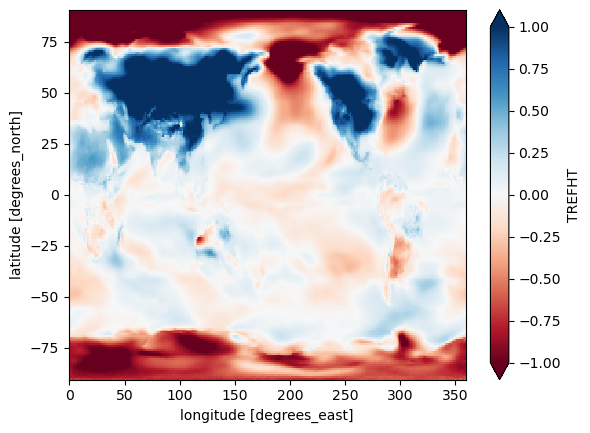

In [251]:
(DS3['TREFHT'].mean('samples') - DS4['TREFHT'].mean('samples')).plot(vmin=-1,vmax=1,cmap='RdBu')

## Examine Suite of Saved States

In [8]:
co2vmr = 0.0004020489956418128
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CESM_LE2_vars_BSSP370cmip6/*1001.001*.nc'))
yt, mt, fout = closest_co2vmr_year(co2vmr, FNS)

if mt != 3:
    print('FUCKKKKK')
    
FNS_year = sorted(glob.glob(f'/glade/derecho/scratch/wchapman/CESM_LE2_vars_BSSP370cmip6/*.{int(fout.split(".")[-2][:4])}*.nc'))
results_da1_TREFHT = extract_closest_co2vmr_data(co2vmr, mt, 'TREFHT', FNS_year)
results_da1_PS = extract_closest_co2vmr_data(co2vmr, mt, 'PS', FNS_year)
results_da1_PRECT = extract_closest_co2vmr_data(co2vmr, mt, 'PRECT', FNS_year)
results_da1 = xr.merge([results_da1_PS, results_da1_PRECT, results_da1_TREFHT])

min dist: 0.0


## Looking at Model vs Obs Bias

In [9]:
climo_tref = results_da1.mean('time')
bias_trefht = []
var = 'TREFHT'
DDS_lens = xs.resample_iterations_idx(results_da1[var], 150, "time") 
lat = DDS_lens['lat']
weights = np.cos(np.deg2rad(lat))
for ii in range(150):
    bias_space = np.sqrt((climo_tref[var]-DDS_lens.sel(iteration=ii,time=slice(0,36)).mean('time'))**2)
    bias_trefht.append(float(bias_space.weighted(weights).mean(dim=['lat', 'lon']).values))

bias_prect = []
var = 'PRECT'
DDS_lens = xs.resample_iterations_idx(results_da1[var], 150, "time") 
for ii in range(150):
    bias_space = np.sqrt((climo_tref[var]-DDS_lens.sel(iteration=ii,time=slice(0,36)).mean('time'))**2)
    bias_prect.append(float(bias_space.weighted(weights).mean(dim=['lat', 'lon']).values))

bias_ps = []
var = 'PS'
DDS_lens = xs.resample_iterations_idx(results_da1[var], 150, "time") 
for ii in range(150):
    bias_space = np.sqrt((climo_tref[var]-DDS_lens.sel(iteration=ii,time=slice(0,36)).mean('time'))**2)
    bias_ps.append(float(bias_space.weighted(weights).mean(dim=['lat', 'lon']).values))

## List of best biases:

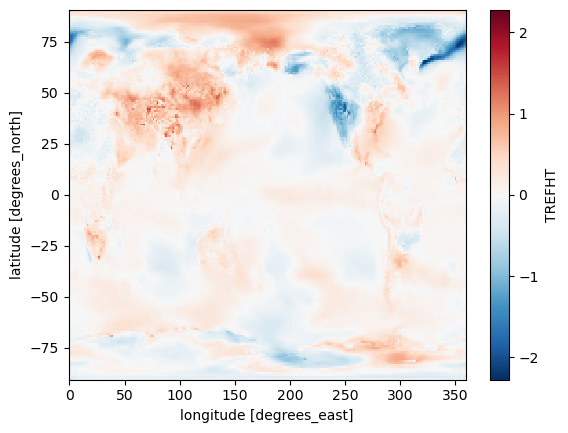

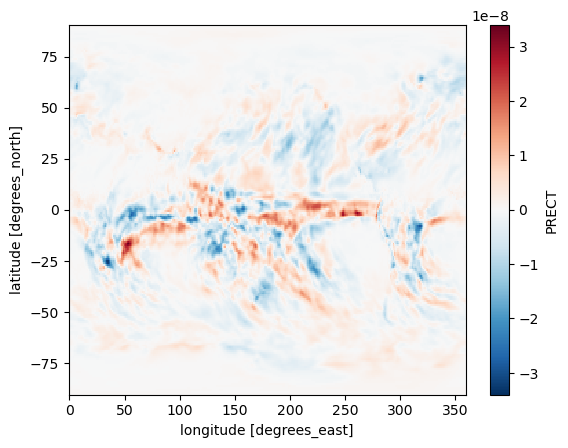

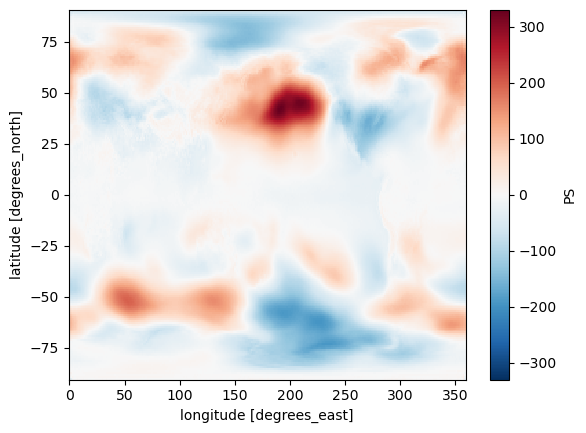

In [13]:
climo_tref = results_da1.mean('time')
FNS = sorted(glob.glob('../results_cc/governance_indexes-*_month_02_co2_0.0004020489956418128.nc'))
bias_mod_prect = []
var = 'PRECT'
for fn in FNS:
    # print(f' doing {fn}')
    DS = xr.open_dataset(fn)
    mod_tref = DS.mean('samples')
    bias_space = np.sqrt((mod_tref[var] - climo_tref[var])**2)
    bias_mod_prect.append(float(bias_space.weighted(weights).mean(dim=['lat', 'lon']).values))

climo_tref = results_da1.mean('time')
FNS = sorted(glob.glob('../results_cc/governance_indexes-*_month_02_co2_0.0004020489956418128.nc'))
bias_mod_ps = []
var = 'PS'
for fn in FNS:
    # print(f' doing {fn}')
    DS = xr.open_dataset(fn)
    mod_tref = DS.mean('samples')
    bias_space = np.sqrt((mod_tref[var] - climo_tref[var])**2)
    bias_mod_ps.append(float(bias_space.weighted(weights).mean(dim=['lat', 'lon']).values))

climo_tref = results_da1.mean('time')
FNS = sorted(glob.glob('../results_cc/governance_indexes-*_month_02_co2_0.0004020489956418128.nc'))
bias_mod_trefht = []
var = 'TREFHT'
for fn in FNS:
    # print(f' doing {fn}')
    DS = xr.open_dataset(fn)
    mod_tref = DS.mean('samples')
    bias_space = np.sqrt((mod_tref[var] - climo_tref[var])**2)
    bias_mod_trefht.append(float(bias_space.weighted(weights).mean(dim=['lat', 'lon']).values))
    

DS = xr.open_dataset(FNS[np.argmin(np.array(bias_mod_trefht))])
mod_tref = DS.mean('samples')
bias_space = ((mod_tref[var] - climo_tref[var]))
(bias_space).plot(cmap='RdBu_r')
plt.show()

DS = xr.open_dataset(FNS[np.argmin(np.array(bias_mod_trefht))])
mod_tref = DS.mean('samples')
bias_space = ((mod_tref['PRECT'] - climo_tref['PRECT']))
(bias_space).plot(cmap='RdBu_r')
plt.show()

DS = xr.open_dataset(FNS[np.argmin(np.array(bias_mod_trefht))])
mod_tref = DS.mean('samples')
bias_space = ((mod_tref['PS'] - climo_tref['PS']))
(bias_space).plot(cmap='RdBu_r')
plt.show()

## Print list of best model candidates

In [31]:
np.argmin(bias_mod_trefht)
def top_x_min_indices(arr, X):
    # Get the indices that would sort the array
    sorted_indices = np.argsort(arr)
    
    # Return the first X indices (the indices of the X smallest values)
    return sorted_indices[:X]

trefht_top_indices = top_x_min_indices(bias_mod_trefht, 35)
prect_top_indices = top_x_min_indices(bias_mod_prect, 35)
ps_top_indices = top_x_min_indices(bias_mod_ps, 35)


# Convert lists to sets and find their intersection
intersection = set(trefht_top_indices).intersection(prect_top_indices).intersection(ps_top_indices)

# Print the results
print('TREFHT:', trefht_top_indices)
print('PRECT:', prect_top_indices)
print('PS:', ps_top_indices)
print('Intersection:', intersection, 'length:', len(intersection))

TREFHT: [71 48 31 55 24 43 27 90 69 33 85 83 11 91 19 23 76  9  1 39 44  6 88 21
 17 28 64 68 86 84 16 14 38 12 72]
PRECT: [21 76 25 33 84 85 71  5  9 55 46 38 69 83 88 43 19 26 24 53 14 67 66 31
 48 74  1 91 42 44 29 12 56 72 18]
PS: [33 17 15 31 72  1 27 85 24 88 16 32 71 49 68 55 69 28 43 11 38 42 53 18
 44 14 12 74 39 83 66 82 51 90 19]
Intersection: {33, 1, 69, 38, 71, 72, 43, 44, 12, 14, 83, 19, 85, 55, 24, 88, 31} length: 17


## Cull the list:

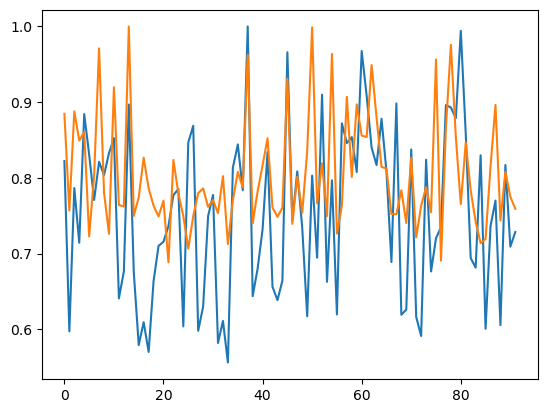

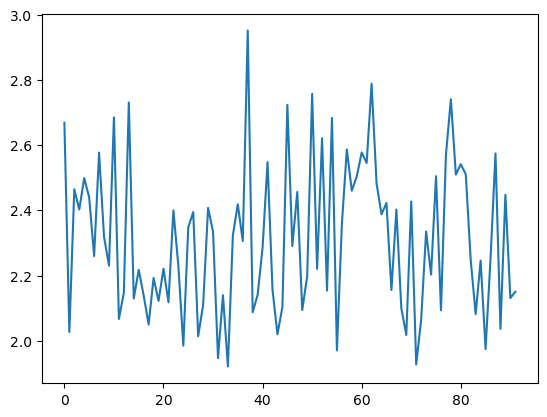

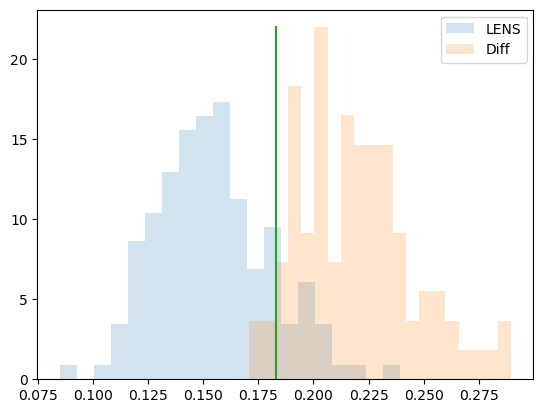

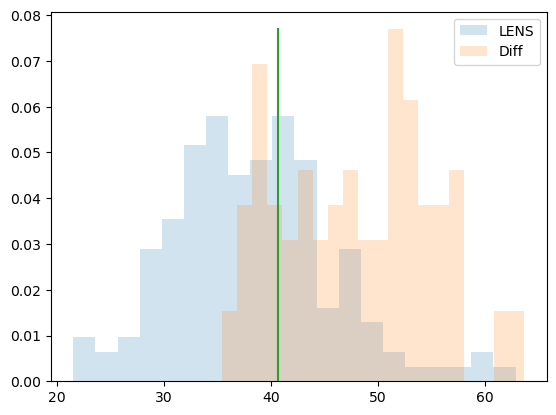

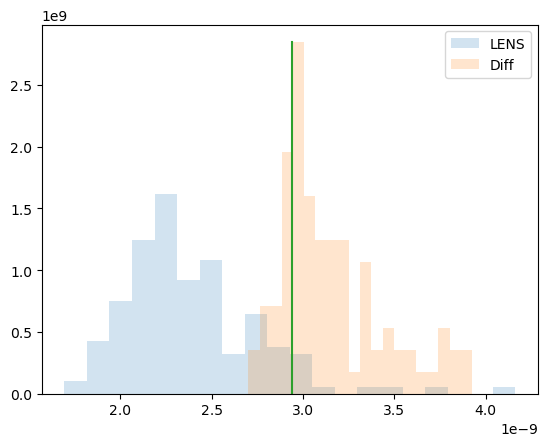

In [94]:
# plt.plot(np.array(bias_mod_trefht) / np.array(bias_mod_trefht).max())
plt.plot(np.array(bias_mod_ps) / np.array(bias_mod_ps).max())
plt.plot(np.array(bias_mod_prect) / np.array(bias_mod_prect).max())
plt.show()

pp = np.array(bias_mod_trefht) / np.array(bias_mod_trefht).max() + np.array(bias_mod_ps) / np.array(bias_mod_ps).max() + np.array(bias_mod_prect) / np.array(bias_mod_prect).max()
plt.plot(pp)
plt.show()

## search pp for low values.
#33 71 38 43 12 24 85 55 -> try to gen with these ones.
#39, 86, 44
try_mod = 43
plt.hist(bias_trefht,bins=20,density=True,alpha=0.2,label='LENS')
aa= plt.hist(bias_mod_trefht,bins=20,density=True,alpha=0.2,label='Diff')
plt.plot([bias_mod_trefht[try_mod],bias_mod_trefht[try_mod]],[0,aa[0].max()])
plt.plot()
plt.legend()
plt.show()

plt.hist(bias_ps,bins=20,density=True,alpha=0.2,label='LENS')
aa = plt.hist(bias_mod_ps,bins=20,density=True,alpha=0.2,label='Diff')
plt.plot([bias_mod_ps[try_mod],bias_mod_ps[try_mod]],[0,aa[0].max()])
plt.legend()
plt.show()

plt.hist(np.array(bias_prect)*1,bins=20,density=True,alpha=0.2,label='LENS')
aa = plt.hist(np.array(bias_mod_prect)*1,bins=20,density=True,alpha=0.2,label='Diff')
plt.plot([bias_mod_prect[try_mod],bias_mod_prect[try_mod]],[0,aa[0].max()])
plt.legend()
plt.show()


## Check the Generated Culled Files

In [65]:
culled_list = [33, 38, 43, 12, 24, 85, 55]
forcing = []
fp = '/glade/derecho/scratch/wchapman/Gen_CESM/'
std_trend = {}
for cl in culled_list:
    print('doing:', cl)
    cl1 =cl+1
    nl = sorted(glob.glob(f'{fp}samples_governance_indexes_39{cl1}_month02_*.nc'))
    bingo =[]
    for ee,nn in enumerate(nl):
        print(f'file {ee:04}')
        DS = xr.open_dataset(nn)
        lat = DS['lat']
        # Calculate weights: cos(lat) in radians
        weights = np.cos(np.deg2rad(lat))
    
        tmean = DS['TREFHT'].weighted(weights).mean(dim=['lat', 'lon','samples'])
        bingo.append(tmean.values)
    std_trend[cl1] = bingo
     

doing: 33
file 0000
file 0001
file 0002
doing: 38
file 0000
file 0001
file 0002
doing: 43
file 0000
file 0001
file 0002
doing: 12
file 0000
file 0001
file 0002
doing: 24
file 0000
file 0001
file 0002
doing: 85
file 0000
file 0001
file 0002
doing: 55
file 0000
file 0001
file 0002


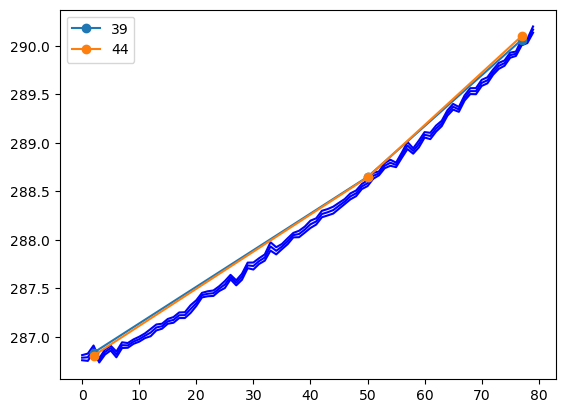

get rid of 34, 56, 25, 13
keep  39, 86, 44


In [93]:
plt.plot(np.array(lens_mea_trend),'b')
plt.plot(np.array(lens_mea_trend)+np.array(lens_std_trend),color='b')
plt.plot(np.array(lens_mea_trend)-np.array(lens_std_trend),color='b')

# plt.plot(np.array([2017,2065,2092])-2015,std_trend[34],'-o',label='34')
plt.plot(np.array([2017,2065,2092])-2015,std_trend[39],'-o',label='39')
plt.plot(np.array([2017,2065,2092])-2015,std_trend[44],'-o',label='44')
# plt.plot(np.array([2017,2065,2092])-2015,std_trend[13],'-o',label='13')
# plt.plot(np.array([2017,2065,2092])-2015,std_trend[25],'-o',label='25')
# plt.plot(np.array([2017,2065,2092])-2015,std_trend[86],'-o',label='86')
# plt.plot(np.array([2017,2065,2092])-2015,std_trend[56],'-o',label='56')
plt.legend()
plt.show()
print('get rid of 34, 56, 25, 13')
print('keep  39, 86, 44')

In [117]:
print('PRECT',bias_mod_prect[71]*1000000000)
print('PRECT',bias_mod_prect[33]*1000000000)
print('PS',bias_mod_ps[71])
print('PS',bias_mod_ps[33])
print('TREFHT',bias_mod_trefht[71])
print('TREFHT',bias_mod_trefht[33])

PRECT 2.830250650457396
PRECT 2.7961009464304065
PS 39.22904934459316
PS 35.397471568431314
TREFHT 0.170763408473662
TREFHT 0.18890871483477203


In [ ]:
plt.hist(bias_trefht,bins=20,density=True,alpha=0.2)
plt.hist(bias_mod_trefht,bins=20,density=True,alpha=0.2)
plt.show()

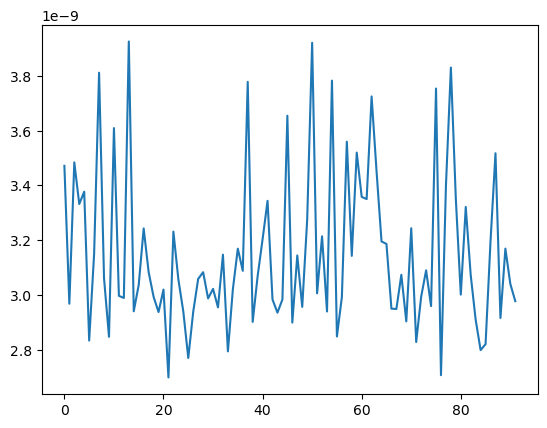

In [115]:
plt.plot(bias_mod_prect)

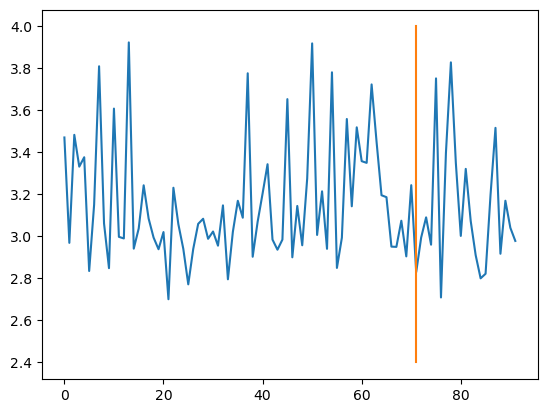

In [89]:
plt.plot(np.array(bias_mod)*1000000000)
plt.plot([71,71],[2.4,4])

In [77]:
np.argmin(np.array(bias_mod))

21

In [ ]:
DS = xr.open_dataset(FNS[np.argmin(np.array(bias_mod))])
mod_tref = DS.mean('samples')
bias_space = ((mod_tref[var] - climo_tref[var]))
(bias_space).plot(cmap='RdBu_r')
plt.show()


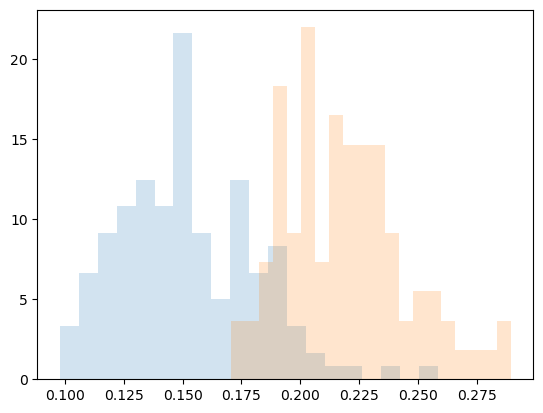

In [116]:
plt.hist(bias_,bins=20,density=True,alpha=0.2)
plt.hist(bias_mod_trefht,bins=20,density=True,alpha=0.2)
plt.show()

In [52]:
co2vmr = 0.0003991389897498876
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CESM_LE2_vars_BSSP370cmip6/*1001.001*.nc'))
yt, mt, fout = closest_co2vmr_year(co2vmr, FNS)

if mt != 3:
    print('FUCKKKKK')
    
FNS_year = sorted(glob.glob(f'/glade/derecho/scratch/wchapman/CESM_LE2_vars_BSSP370cmip6/*.{int(fout.split(".")[-2][:4])}*.nc'))
results_da1_TREFHT = extract_closest_co2vmr_data(co2vmr, mt, 'TREFHT', FNS_year)
results_da1_PS = extract_closest_co2vmr_data(co2vmr, mt, 'PS', FNS_year)
results_da1_PRECT = extract_closest_co2vmr_data(co2vmr, mt, 'PRECT', FNS_year)
results_da1 = xr.merge([results_da1_PS, results_da1_PRECT, results_da1_TREFHT])

min dist: 0.0


In [44]:
indir='/glade/derecho/scratch/wchapman/Gen_CESM/'
DS = xr.open_dataset(f'{indir}/samples_governance_indexes_3971_month02_co20.0003991389897498876_001.nc')

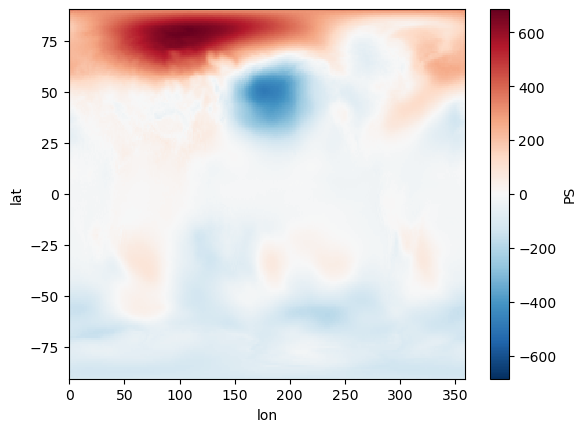

In [59]:
(results_da1['PS'].mean('time') - DS['PS'].mean('samples')).plot()

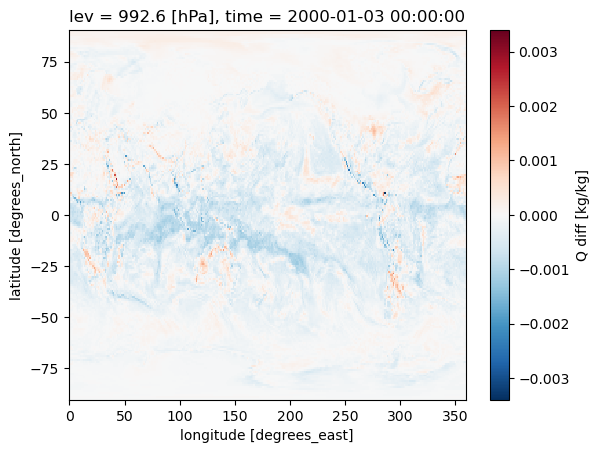

In [78]:
DS = xr.open_dataset('/glade/derecho/scratch/wchapman/archive/f.e21.REPLAY/atm/hist/f.e21.REPLAY.cam.h1.2000-01-03-00000.nc')
DS['QDIFF'].squeeze().sel(lev=1000,method='nearest').plot()